In [ ]:
from notebooks import *

In [ ]:
load = Load()
recs = recs if 'recs' in locals() else load.recs(
    # limit=30,  # XXX Faster dev
    datasets=[
        'peterson-field-guide',
        # 'recordings',
    ],
)
display(
    # df_summary(recs).T,
    # df_summary(recs),
    # recs[:5],
)

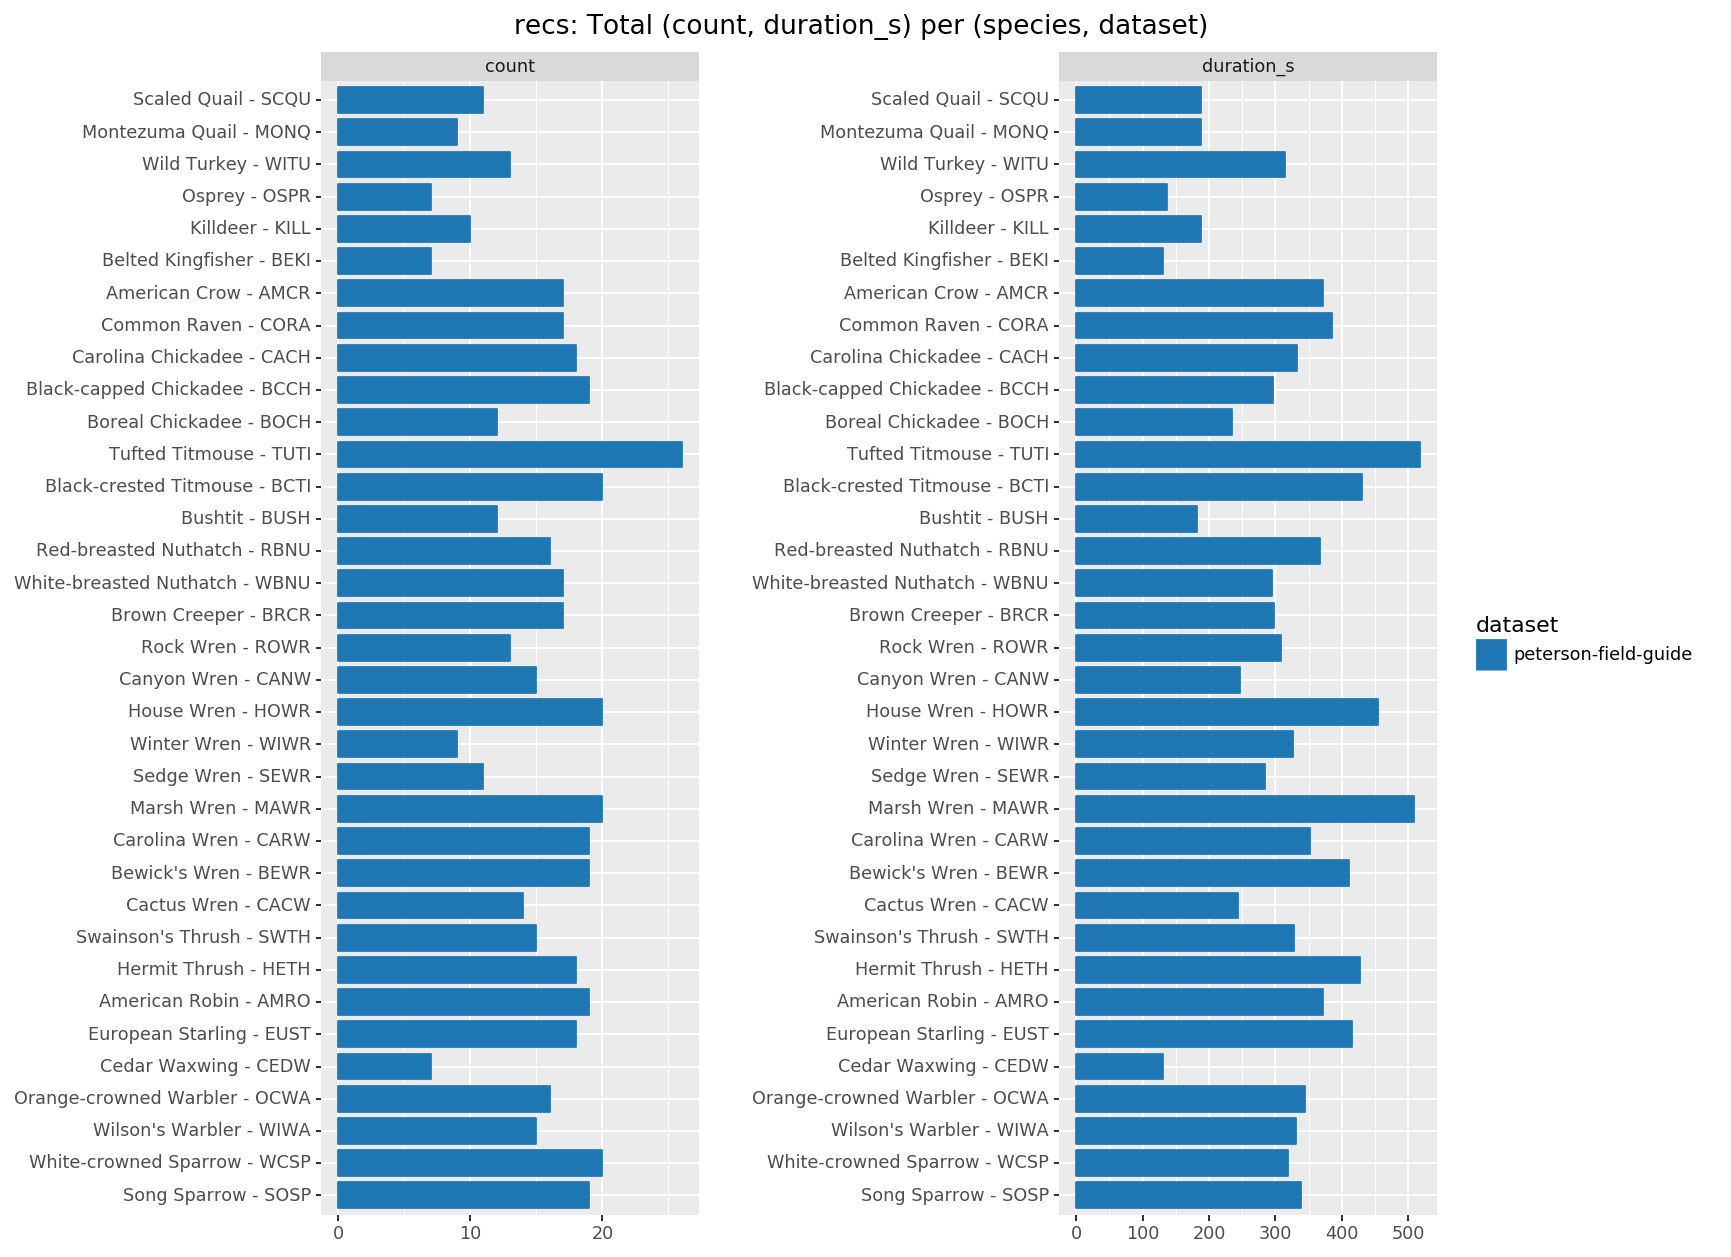

<ggplot: (-9223372036535889201)>

In [ ]:
(recs
    .assign(species=lambda df: df.species_longhand)
    .assign(count=1)
    # 0-fill all (species, dataset) combinations to create empty placeholders for missing bars
    .pipe(lambda df: df.append(
        pd.DataFrame([
            dict(species=species, dataset=dataset, duration_s=0)
            for species in df.species.unique()
            for dataset in df.dataset.unique()
        ])
        .astype({'species': df.species.dtype})
    ))
    .groupby(['dataset', 'species'])[['count', 'duration_s']].sum().reset_index()
    .pipe(pd.melt, id_vars=['dataset', 'species'], value_vars=['count', 'duration_s'])
    .pipe(df_reverse_cat, 'species')
    .pipe(ggplot, aes(x='species', y='value', fill='dataset', color='dataset'))
    + coord_flip()
    + geom_bar(stat='identity', position=position_dodge(), width=.8)
    + facet_wrap('variable', nrow=1, scales='free')
    + xlab('')
    + ylab('')
    + scale_fill_cmap_d(mpl.cm.tab10)
    + scale_color_cmap_d(mpl.cm.tab10)
    + theme(panel_spacing=2.5)
    + theme_figsize(width=10, aspect_ratio=3/1)
    + ggtitle(f'recs: Total (count, duration_s) per (species, dataset)')
)

In [ ]:
# Load a saved projection model
projection = Projection.load('peterson-v0-26bae1c', features=Features(load=load))

[03:17:39.019] Projection.load
  path: /Users/danb/hack/bubo/data/models/projection/peterson-v0-26bae1c.pkl


In [ ]:
# Add .feat
recs = projection.transform(recs)

In [ ]:
# GridSearchCV many models / model params
param_grid = dict(
    classifier=[

        # KNN
        #   - Bad for large k because we only have ~7-26 instances per class
        #   - Bad for small k because KNN
        # 'cls: knn, n_neighbors: 100',
        'cls: knn, n_neighbors: 50',
        'cls: knn, n_neighbors: 25',
        # 'cls: knn, n_neighbors: 15',
        'cls: knn, n_neighbors: 10',
        'cls: knn, n_neighbors: 5',
        'cls: knn, n_neighbors: 3',
        'cls: knn, n_neighbors: 1',

        # SVM(RBF)
        #   - [SBF16] Uses these
        'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 1',
        'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 10',  # [SBF16]
        'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 100',  # Same as C:10 [why?]
        # 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 1000',  # Same as C:10 [why?]

        # RandomForest(entropy)
        #   - [SP14] uses entropy
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 10',
        'cls: rf, random_state: 0, criterion: entropy, n_estimators: 50',
        'cls: rf, random_state: 0, criterion: entropy, n_estimators: 100',
        'cls: rf, random_state: 0, criterion: entropy, n_estimators: 200',  # [SP14]
        'cls: rf, random_state: 0, criterion: entropy, n_estimators: 400',

        # RandomForest(gini)
        #   - sk uses gini by default
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 10',  # [sk default]
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 50',
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 100',
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 200',
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 400',
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 600',
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 800',
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 1000',

    ]
    # TODO agg_funs
)

# TODO Increase cv to decrease variance in eval metrics (this made Alex extremely squirmy)
cv = GridSearchCVCached(
    estimator=Search(projection=projection),
    param_grid=param_grid,
    # cv=3,  # [SP14] uses two-/three-fold CV [why?]
    cv=sk.model_selection.ShuffleSplit(
        # n_splits=1,
        # n_splits=2,
        # n_splits=5,
        # n_splits=10,
        n_splits=20,  # Known good
        # n_splits=100,  # [29.6m runtime, 36.9g disk cache]
        test_size=.2,
        random_state=0,
    ),
    return_train_score=True,
    extra_metrics=dict(
        # [How to specify SearchEvals here without creating caching headaches?]
        #   - e.g. defs don't bust cache on code edit
        #   - And avoid thrashing cache every time we refactor SearchEvals
        test_i='i_test',
        test_y='y_test',
        test_classes='estimator.classes_',
        test_predict_proba='estimator.classifier_.predict_proba(X_test)',
    ),
    # return_estimator=True,  # Verrrry heavy, use extra_metrics instead
    # verbose=100,
    # verbose=10,  # O(models * n_splits) lines of outputs
    verbose=1,  # O(1) lines of outputs
    # n_jobs=1,  # For %prun
    # n_jobs=8,
    n_jobs=16,
)
with contextlib.ExitStack() as stack:
    # stack.enter_context(cache_control(refresh=True))
    # stack.enter_context(joblib.parallel_backend('threading'))  # Default: 'multiprocessing'
    # stack.enter_context(joblib.parallel_backend('sequential'))  # For %prun [FIXME Has no effect; why?]
    stack.enter_context(log.context(verbose=False))
    X, y = Search.Xy(recs)
    cv.fit(X, y)

Fitting 20 folds for each of 20 candidates, totalling 400 fits


.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s


.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

[Parallel(n_jobs=16)]: Done 400 out of 400 | elapsed:    1.5s finished


In [ ]:
# Precompute eval metrics + dims for the plots below
#   - Grain: models
#   - Metrics: train_score, test_score, ...
#   - Dims: model_id, classifier_type, fold, ...
cv_models = (cv_results_splits_df(cv.cv_results_)
    # .params
    .assign(
        # Slow yaml parsing, compute up front
        params_dict=lambda df: df.apply(axis=1, func=lambda row: {
            'classifier': yaml.safe_load('{%s}' % row.param_classifier),
            # TODO More param_*
        }),
        params=lambda df: (
            df.pop('param_classifier')
            # TODO More param_*
        ),
    )
    # Dims from params
    .assign(
        classifier_type=lambda df: df.params_dict.str['classifier'].apply(lambda x: (
            '%s-%s' % (x['cls'], x['criterion']) if x['cls'] == 'rf' else
            x['cls']
        )),
    )
    # .eval
    .assign(test_evals=lambda df: np.vectorize(SearchEvals)(
        i=df.pop('test_i'),
        y=df.pop('test_y'),
        classes=df.pop('test_classes'),
        y_scores=df.pop('test_predict_proba'),
    ))
    # Reorder
    .pipe(df_reorder_cols, first=[
        'model_id', 'params', 'params_dict', 'classifier_type',
    ])
)
display(
    df_summary(cv_models).T,
    cv_models[:5],
)

min                                 25%                                                                      50%                                                                   75%                                                                       max
                dtype   sizeof   len count nunique mean std                                                                                                                                                                                                                                                                                                 
model_id        object  43600    400 400   400.0   NaN  NaN  cls: knn, n_neighbors: 10; fold: 0  cls: knn, n_neighbors: 50; fold: 9  cls: rf, random_state: 0, criterion: entropy, n_estimators: 50; fold: 9  cls: rf, random_state: 0, criterion: gini, n_estimators: 50; fold: 9  cls: svm, random_state: 0, probability: true, kernel: rbf, C: 1; fold: 9
params          object  39800    400 400   20.0    NaN  NaN            cls: knn, n_neighbors: 1            cls: knn, n_neighbors: 5           cls: rf, random_state: 0, criterion: entropy, n_estimators: 50           cls: rf, random_state: 0, criterion: gini, n_estimators: 50         cls: svm, random_state: 0, probability: true, kernel: rbf, C: 100
params_dict     object  96000    400 400   NaN     NaN  NaN                                 NaN                                 NaN                                                                      NaN                                                                   NaN                                                                       NaN
classifier_type object  21920    400 400   4.0     NaN  NaN                                 knn                                 knn                                                               rf-entropy                                                               rf-gini                                                                       svm
fold            int64   11120    400 400   20.0    NaN  NaN                                   0                                   4                                                                        9                                                                    14                                                                        19
train_score     float64 9600     400 400   4.0     NaN  NaN                                  -4                                  -2                                                                       -1                                                                    -1                                                                        -1
test_score      float64 9600     400 400   8.0     NaN  NaN                                 -35                                  -5                                                                       -3                                                                    -3                                                                        -2
test_evals      object  13486800 400 400   NaN     NaN  NaN                                 NaN                                 NaN                                                                      NaN                                                                   NaN                                                                       NaN

model_id                     params                                        params_dict classifier_type  fold  train_score  test_score                                                              test_evals
0  cls: knn, n_neighbors: 50; fold: 0  cls: knn, n_neighbors: 50  {'classifier': {'cls': 'knn', 'n_neighbors': 50}}             knn     0         -4.0        -7.0  SearchEvals(i[(107,)], y[(107,)], classes[(35,)], y_scores[(107, 35)])
1  cls: knn, n_neighbors: 50; fold: 1  cls: knn, n_neighbors: 50  {'classifier': {'cls': 'knn', 'n_neighbors': 50}}             knn     1         -4.0        -7.0  SearchEvals(i[(107,)], y[(107,)], classes[(35,)], y_scores[(107, 35)])
2  cls: knn, n_neighbors: 50; fold: 2  cls: knn, n_neighbors: 50  {'classifier': {'cls': 'knn', 'n_neighbors': 50}}             knn     2         -4.0        -7.0  SearchEvals(i[(107,)], y[(107,)], classes[(35,)], y_scores[(107, 35)])
3  cls: knn, n_neighbors: 50; fold: 3  cls: knn, n_neighbors: 50  {'classifier': {'cls': 'knn', 'n_neighbors': 50}}             knn     3         -4.0        -6.0  SearchEvals(i[(107,)], y[(107,)], classes[(35,)], y_scores[(107, 35)])
4  cls: knn, n_neighbors: 50; fold: 4  cls: knn, n_neighbors: 50  {'classifier': {'cls': 'knn', 'n_neighbors': 50}}             knn     4         -4.0        -7.0  SearchEvals(i[(107,)], y[(107,)], classes[(35,)], y_scores[(107, 35)])

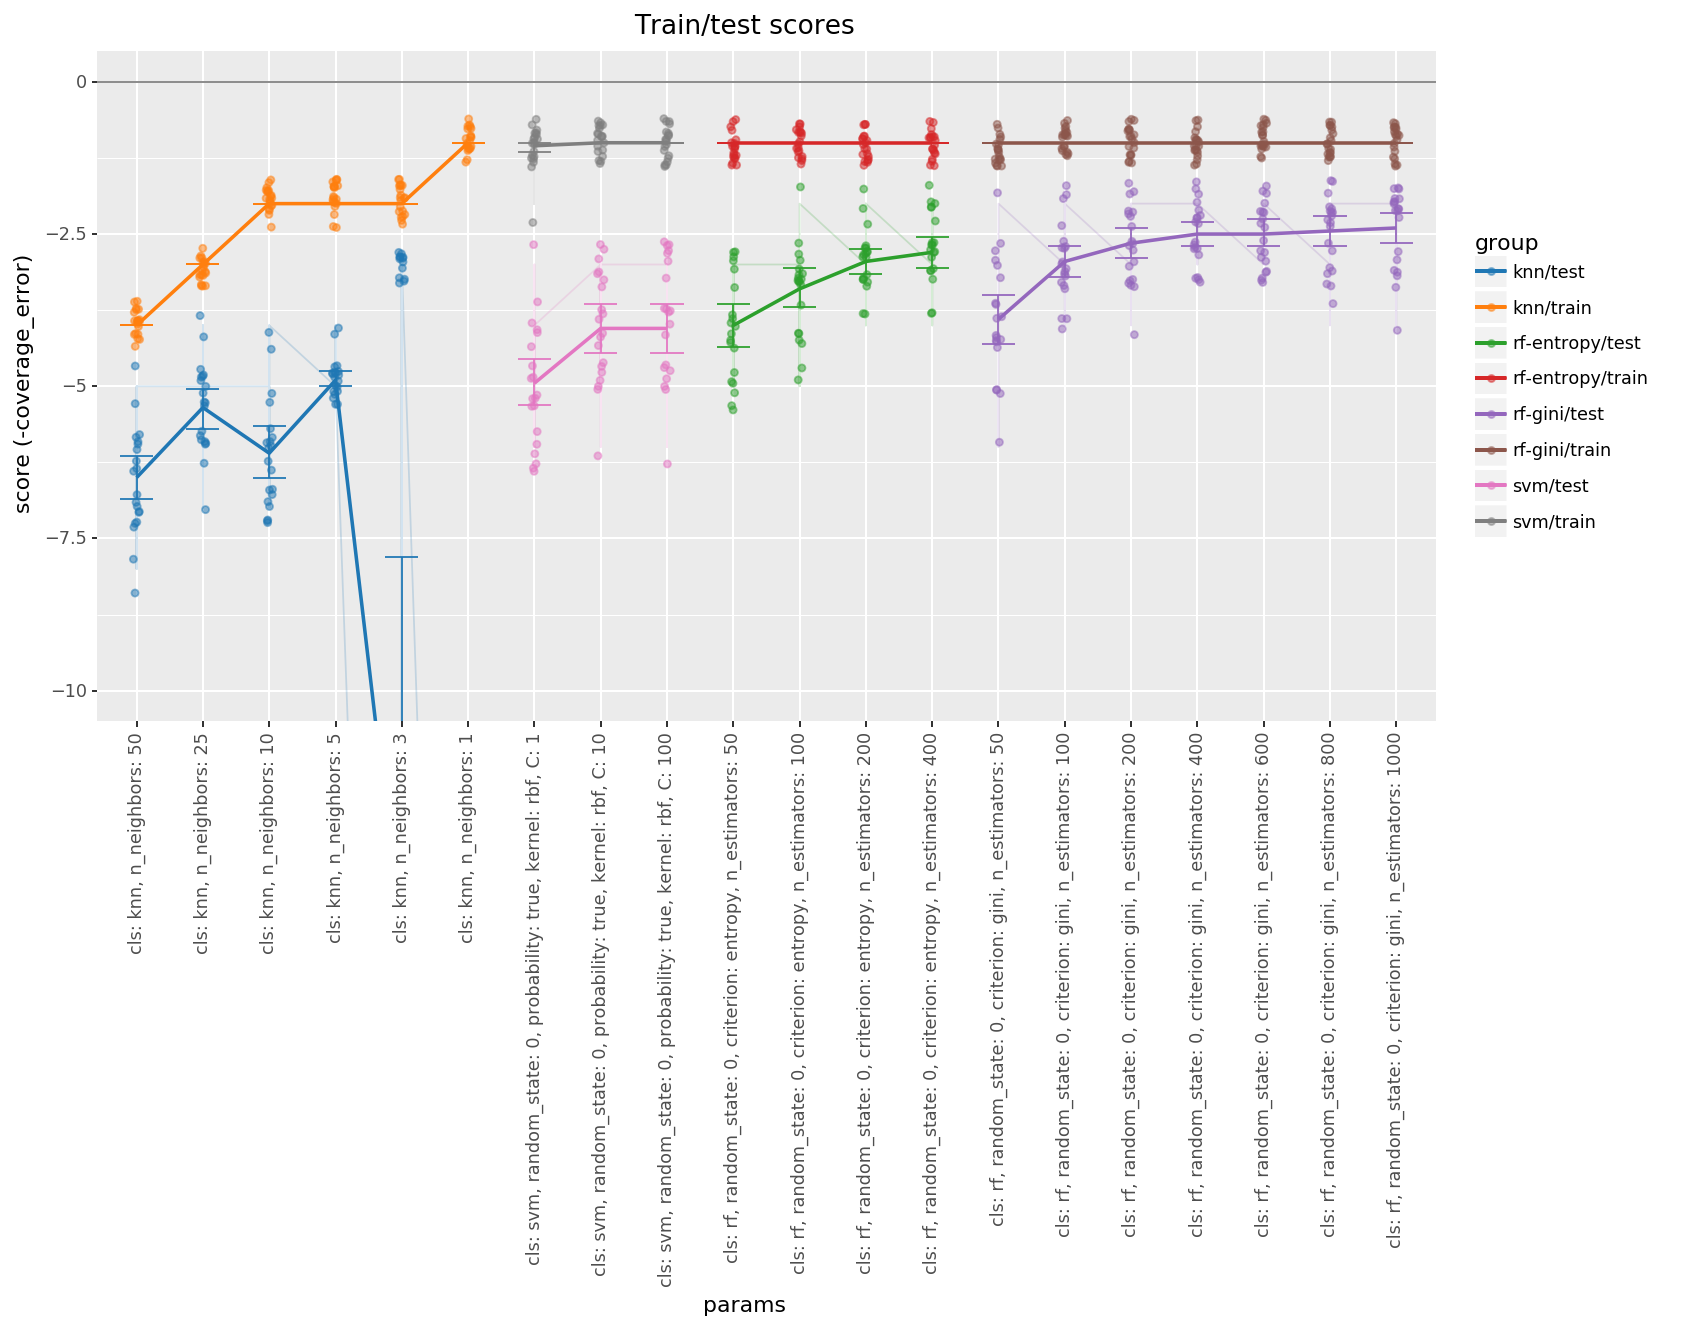

<ggplot: (-9223372036532062085)>

In [ ]:
# Train/test scores
#   - Grain: models x {train,test}
#   - Metrics: score
#   - Dims: group, params
(cv_models
    .pipe(lambda df: pd.melt(
        df,
        id_vars=['classifier_type', 'params', 'fold'],
        value_vars=['train_score', 'test_score'],
        var_name='split',
        value_name='score'),
    )
    .assign(
        split=lambda df: df.split.str.replace('_score', ''),
        group=lambda df: df.apply(axis=1, func=lambda row: row.classifier_type + '/' + row.split),
    )
    .pipe(df_ordered_cat, params=lambda df: param_grid['classifier'])
    .pipe(ggplot, aes(x='params', y='score', color='group'))
    + geom_hline(yintercept=0, color='grey')
    + geom_jitter(alpha=.5, width=.05)
    + geom_line(aes(group='group + str(fold)'), alpha=.2)
    + stat_summary(aes(group='group'), fun_data='mean_cl_boot', random_state=0, geom='errorbar')
    + stat_summary(aes(group='group'), fun_data='mean_cl_boot', random_state=0, geom='line', size=1)
    + scale_color_cmap_d(mpl.cm.tab10)
    + theme(axis_text_x=element_text(angle=90, hjust=.5))
    + theme_figsize(width=12, aspect_ratio=1/2)
    + coord_cartesian(ylim=(-10, 0))
    + ylab('score (-coverage_error)')
    + ggtitle('Train/test scores')
)

# Model diagnostics: all models, all folds

In [ ]:
print('models:')
print('  params[*/%s]' % len(param_grid['classifier']))
print('  fold[*/%s]' % cv.cv.n_splits)

models:
  params[*/19]
  fold[*/100]


In [ ]:
# TODO TODO Bubble down
#   - Subset: all models
#   - Grain: models
#   - Dims: model_id, params, classifier_type, fold, y_true
#   - Metrics: train_score, test_score, test_evals
(cv_models
    [:5]
)

model_id                    params                                       params_dict classifier_type  fold  train_score  test_score                                                              test_evals
0  cls: knn, n_neighbors: 1; fold: 0  cls: knn, n_neighbors: 1  {'classifier': {'cls': 'knn', 'n_neighbors': 1}}             knn     0         -1.0       -35.0  SearchEvals(i[(107,)], y[(107,)], classes[(35,)], y_scores[(107, 35)])
1  cls: knn, n_neighbors: 1; fold: 1  cls: knn, n_neighbors: 1  {'classifier': {'cls': 'knn', 'n_neighbors': 1}}             knn     1         -1.0       -35.0  SearchEvals(i[(107,)], y[(107,)], classes[(35,)], y_scores[(107, 35)])
2  cls: knn, n_neighbors: 1; fold: 2  cls: knn, n_neighbors: 1  {'classifier': {'cls': 'knn', 'n_neighbors': 1}}             knn     2         -1.0       -35.0  SearchEvals(i[(107,)], y[(107,)], classes[(35,)], y_scores[(107, 35)])
3  cls: knn, n_neighbors: 1; fold: 3  cls: knn, n_neighbors: 1  {'classifier': {'cls': 'knn', 'n_neighbors': 1}}             knn     3         -1.0       -35.0  SearchEvals(i[(107,)], y[(107,)], classes[(35,)], y_scores[(107, 35)])
4  cls: knn, n_neighbors: 1; fold: 4  cls: knn, n_neighbors: 1  {'classifier': {'cls': 'knn', 'n_neighbors': 1}}             knn     4         -1.0       -35.0  SearchEvals(i[(107,)], y[(107,)], classes[(35,)], y_scores[(107, 35)])

In [ ]:
# TODO Cache
# Coverage errors: all models, all folds
#   - Subset: all models
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_all_all = (cv_models
    # .sample(n=5, random_state=0)  # For faster dev
    .pipe(lambda df: DF(
        OrderedDict(
            # **row[['model_id', 'params', 'fold']],  # Slow (in this inner loop), unpack manually instead
            model_id=row.model_id,
            params=row.params,
            classifier_type=row.classifier_type,
            fold=row.fold,
            i=i,
            y_true=y_true,
            coverage_error=coverage_error,
        )
        for row in iter_progress(df_rows(df), n=len(df))
        for i, y_true, coverage_error in zip(
            row.test_evals.i,
            row.test_evals.y,
            row.test_evals.coverage_errors(),
        )
    ))
)
display(
    df_summary(coverage_errors_all_all).T,
    coverage_errors_all_all[:10],
)

  0%|                                                                                         | 0/1900 [00:00<?, ?it/s]

  0%|▏                                                                                | 3/1900 [00:00<01:10, 26.74it/s]

  0%|▎                                                                                | 6/1900 [00:00<01:10, 26.83it/s]

  0%|▍                                                                                | 9/1900 [00:00<01:11, 26.40it/s]

  1%|▌                                                                               | 12/1900 [00:00<01:10, 26.80it/s]

  1%|▋                                                                               | 15/1900 [00:00<01:10, 26.87it/s]

  1%|▊                                                                               | 18/1900 [00:00<01:10, 26.74it/s]

  1%|▉                                                                               | 21/1900 [00:00<01:11, 26.42it/s]

  1%|█                                                                               | 24/1900 [00:00<01:11, 26.07it/s]

  1%|█▏                                                                              | 27/1900 [00:01<01:12, 25.71it/s]

  2%|█▎                                                                              | 30/1900 [00:01<01:12, 25.84it/s]

  2%|█▍                                                                              | 33/1900 [00:01<01:12, 25.85it/s]

  2%|█▌                                                                              | 36/1900 [00:01<01:12, 25.80it/s]

  2%|█▋                                                                              | 39/1900 [00:01<01:11, 25.89it/s]

  2%|█▊                                                                              | 42/1900 [00:01<01:11, 25.90it/s]

  2%|█▉                                                                              | 45/1900 [00:01<01:11, 25.77it/s]

  3%|██                                                                              | 48/1900 [00:01<01:11, 25.73it/s]

  3%|██▏                                                                             | 51/1900 [00:01<01:11, 25.77it/s]

  3%|██▎                                                                             | 54/1900 [00:02<01:11, 25.76it/s]

  3%|██▍                                                                             | 57/1900 [00:02<01:11, 25.80it/s]

  3%|██▌                                                                             | 60/1900 [00:02<01:11, 25.75it/s]

  3%|██▋                                                                             | 63/1900 [00:02<01:11, 25.84it/s]

  3%|██▊                                                                             | 66/1900 [00:02<01:10, 25.89it/s]

  4%|██▉                                                                             | 69/1900 [00:02<01:10, 25.88it/s]

  4%|███                                                                             | 72/1900 [00:02<01:10, 25.84it/s]

  4%|███▏                                                                            | 75/1900 [00:02<01:10, 25.84it/s]

  4%|███▎                                                                            | 78/1900 [00:03<01:10, 25.81it/s]

  4%|███▍                                                                            | 81/1900 [00:03<01:10, 25.78it/s]

  4%|███▌                                                                            | 84/1900 [00:03<01:10, 25.69it/s]

  5%|███▋                                                                            | 87/1900 [00:03<01:10, 25.73it/s]

  5%|███▊                                                                            | 90/1900 [00:03<01:10, 25.75it/s]

  5%|███▉                                                                            | 93/1900 [00:03<01:10, 25.76it/s]

  5%|████                                                                            | 96/1900 [00:03<01:10, 25.72it/s]

  5%|████▏                                                                           | 99/1900 [00:03<01:10, 25.72it/s]

  5%|████▏                                                                          | 102/1900 [00:03<01:09, 25.71it/s]

  6%|████▎                                                                          | 105/1900 [00:04<01:09, 25.74it/s]

  6%|████▍                                                                          | 108/1900 [00:04<01:09, 25.72it/s]

  6%|████▌                                                                          | 111/1900 [00:04<01:09, 25.71it/s]

  6%|████▋                                                                          | 114/1900 [00:04<01:09, 25.72it/s]

  6%|████▊                                                                          | 117/1900 [00:04<01:09, 25.75it/s]

  6%|████▉                                                                          | 120/1900 [00:04<01:09, 25.74it/s]

  6%|█████                                                                          | 123/1900 [00:04<01:08, 25.77it/s]

  7%|█████▏                                                                         | 126/1900 [00:04<01:08, 25.79it/s]

  7%|█████▎                                                                         | 129/1900 [00:04<01:08, 25.82it/s]

  7%|█████▍                                                                         | 132/1900 [00:05<01:08, 25.82it/s]

  7%|█████▌                                                                         | 135/1900 [00:05<01:08, 25.80it/s]

  7%|█████▋                                                                         | 138/1900 [00:05<01:08, 25.79it/s]

  7%|█████▊                                                                         | 141/1900 [00:05<01:08, 25.78it/s]

  8%|█████▉                                                                         | 144/1900 [00:05<01:08, 25.80it/s]

  8%|██████                                                                         | 147/1900 [00:05<01:07, 25.78it/s]

  8%|██████▏                                                                        | 150/1900 [00:05<01:07, 25.74it/s]

  8%|██████▎                                                                        | 153/1900 [00:05<01:07, 25.72it/s]

  8%|██████▍                                                                        | 156/1900 [00:06<01:07, 25.70it/s]

  8%|██████▌                                                                        | 159/1900 [00:06<01:07, 25.69it/s]

  9%|██████▋                                                                        | 162/1900 [00:06<01:07, 25.67it/s]

  9%|██████▊                                                                        | 165/1900 [00:06<01:07, 25.68it/s]

  9%|██████▉                                                                        | 168/1900 [00:06<01:07, 25.67it/s]

  9%|███████                                                                        | 171/1900 [00:06<01:07, 25.68it/s]

  9%|███████▏                                                                       | 174/1900 [00:06<01:07, 25.67it/s]

  9%|███████▎                                                                       | 177/1900 [00:06<01:07, 25.67it/s]

  9%|███████▍                                                                       | 180/1900 [00:07<01:06, 25.70it/s]

 10%|███████▌                                                                       | 183/1900 [00:07<01:06, 25.68it/s]

 10%|███████▋                                                                       | 186/1900 [00:07<01:06, 25.71it/s]

 10%|███████▊                                                                       | 189/1900 [00:07<01:06, 25.70it/s]

 10%|███████▉                                                                       | 192/1900 [00:07<01:06, 25.71it/s]

 10%|████████                                                                       | 195/1900 [00:07<01:06, 25.73it/s]

 10%|████████▏                                                                      | 198/1900 [00:07<01:06, 25.73it/s]

 11%|████████▎                                                                      | 201/1900 [00:07<01:06, 25.73it/s]

 11%|████████▍                                                                      | 204/1900 [00:07<01:05, 25.73it/s]

 11%|████████▌                                                                      | 207/1900 [00:08<01:05, 25.72it/s]

 11%|████████▋                                                                      | 210/1900 [00:08<01:05, 25.72it/s]

 11%|████████▊                                                                      | 213/1900 [00:08<01:05, 25.68it/s]

 11%|████████▉                                                                      | 216/1900 [00:08<01:05, 25.67it/s]

 12%|█████████                                                                      | 219/1900 [00:08<01:05, 25.66it/s]

 12%|█████████▏                                                                     | 222/1900 [00:08<01:05, 25.63it/s]

 12%|█████████▎                                                                     | 225/1900 [00:08<01:05, 25.63it/s]

 12%|█████████▍                                                                     | 228/1900 [00:08<01:05, 25.63it/s]

 12%|█████████▌                                                                     | 231/1900 [00:09<01:05, 25.63it/s]

 12%|█████████▋                                                                     | 234/1900 [00:09<01:04, 25.64it/s]

 12%|█████████▊                                                                     | 237/1900 [00:09<01:04, 25.64it/s]

 13%|█████████▉                                                                     | 240/1900 [00:09<01:04, 25.64it/s]

 13%|██████████                                                                     | 243/1900 [00:09<01:04, 25.63it/s]

 13%|██████████▏                                                                    | 246/1900 [00:09<01:04, 25.65it/s]

 13%|██████████▎                                                                    | 249/1900 [00:09<01:04, 25.64it/s]

 13%|██████████▍                                                                    | 252/1900 [00:09<01:04, 25.64it/s]

 13%|██████████▌                                                                    | 255/1900 [00:09<01:04, 25.62it/s]

 14%|██████████▋                                                                    | 258/1900 [00:10<01:04, 25.60it/s]

 14%|██████████▊                                                                    | 261/1900 [00:10<01:04, 25.58it/s]

 14%|██████████▉                                                                    | 264/1900 [00:10<01:03, 25.58it/s]

 14%|███████████                                                                    | 267/1900 [00:10<01:03, 25.57it/s]

 14%|███████████▏                                                                   | 270/1900 [00:10<01:03, 25.57it/s]

 14%|███████████▎                                                                   | 273/1900 [00:10<01:03, 25.59it/s]

 15%|███████████▍                                                                   | 276/1900 [00:10<01:03, 25.57it/s]

 15%|███████████▌                                                                   | 279/1900 [00:10<01:03, 25.56it/s]

 15%|███████████▋                                                                   | 282/1900 [00:11<01:03, 25.56it/s]

 15%|███████████▊                                                                   | 285/1900 [00:11<01:03, 25.55it/s]

 15%|███████████▉                                                                   | 288/1900 [00:11<01:03, 25.56it/s]

 15%|████████████                                                                   | 291/1900 [00:11<01:02, 25.56it/s]

 15%|████████████▏                                                                  | 294/1900 [00:11<01:02, 25.58it/s]

 16%|████████████▎                                                                  | 297/1900 [00:11<01:02, 25.59it/s]

 16%|████████████▍                                                                  | 300/1900 [00:11<01:02, 25.59it/s]

 16%|████████████▌                                                                  | 303/1900 [00:11<01:02, 25.60it/s]

 16%|████████████▋                                                                  | 306/1900 [00:11<01:02, 25.59it/s]

 16%|████████████▊                                                                  | 309/1900 [00:12<01:02, 25.59it/s]

 16%|████████████▉                                                                  | 312/1900 [00:12<01:02, 25.60it/s]

 17%|█████████████                                                                  | 315/1900 [00:12<01:01, 25.61it/s]

 17%|█████████████▏                                                                 | 318/1900 [00:12<01:01, 25.62it/s]

 17%|█████████████▎                                                                 | 321/1900 [00:12<01:01, 25.63it/s]

 17%|█████████████▍                                                                 | 324/1900 [00:12<01:01, 25.63it/s]

 17%|█████████████▌                                                                 | 327/1900 [00:12<01:01, 25.63it/s]

 17%|█████████████▋                                                                 | 330/1900 [00:12<01:01, 25.64it/s]

 18%|█████████████▊                                                                 | 333/1900 [00:12<01:01, 25.65it/s]

 18%|█████████████▉                                                                 | 336/1900 [00:13<01:00, 25.65it/s]

 18%|██████████████                                                                 | 339/1900 [00:13<01:00, 25.66it/s]

 18%|██████████████▏                                                                | 342/1900 [00:13<01:00, 25.67it/s]

 18%|██████████████▎                                                                | 345/1900 [00:13<01:00, 25.66it/s]

 18%|██████████████▍                                                                | 348/1900 [00:13<01:00, 25.67it/s]

 18%|██████████████▌                                                                | 351/1900 [00:13<01:00, 25.67it/s]

 19%|██████████████▋                                                                | 354/1900 [00:13<01:00, 25.68it/s]

 19%|██████████████▊                                                                | 357/1900 [00:13<01:00, 25.68it/s]

 19%|██████████████▉                                                                | 360/1900 [00:14<00:59, 25.69it/s]

 19%|███████████████                                                                | 363/1900 [00:14<00:59, 25.68it/s]

 19%|███████████████▏                                                               | 366/1900 [00:14<00:59, 25.69it/s]

 19%|███████████████▎                                                               | 369/1900 [00:14<00:59, 25.69it/s]

 20%|███████████████▍                                                               | 372/1900 [00:14<00:59, 25.68it/s]

 20%|███████████████▌                                                               | 375/1900 [00:14<00:59, 25.68it/s]

 20%|███████████████▋                                                               | 378/1900 [00:14<00:59, 25.69it/s]

 20%|███████████████▊                                                               | 381/1900 [00:14<00:59, 25.70it/s]

 20%|███████████████▉                                                               | 384/1900 [00:14<00:59, 25.69it/s]

 20%|████████████████                                                               | 387/1900 [00:15<00:58, 25.71it/s]

 21%|████████████████▏                                                              | 390/1900 [00:15<00:58, 25.70it/s]

 21%|████████████████▎                                                              | 393/1900 [00:15<00:58, 25.70it/s]

 21%|████████████████▍                                                              | 396/1900 [00:15<00:58, 25.71it/s]

 21%|████████████████▌                                                              | 399/1900 [00:15<00:58, 25.72it/s]

 21%|████████████████▋                                                              | 402/1900 [00:15<00:58, 25.73it/s]

 21%|████████████████▊                                                              | 405/1900 [00:15<00:58, 25.74it/s]

 21%|████████████████▉                                                              | 408/1900 [00:15<00:57, 25.74it/s]

 22%|█████████████████                                                              | 411/1900 [00:15<00:57, 25.74it/s]

 22%|█████████████████▏                                                             | 414/1900 [00:16<00:57, 25.75it/s]

 22%|█████████████████▎                                                             | 417/1900 [00:16<00:57, 25.76it/s]

 22%|█████████████████▍                                                             | 420/1900 [00:16<00:57, 25.77it/s]

 22%|█████████████████▌                                                             | 423/1900 [00:16<00:57, 25.76it/s]

 22%|█████████████████▋                                                             | 426/1900 [00:16<00:57, 25.77it/s]

 23%|█████████████████▊                                                             | 429/1900 [00:16<00:57, 25.78it/s]

 23%|█████████████████▉                                                             | 432/1900 [00:16<00:56, 25.76it/s]

 23%|██████████████████                                                             | 435/1900 [00:16<00:56, 25.76it/s]

 23%|██████████████████▏                                                            | 438/1900 [00:16<00:56, 25.76it/s]

 23%|██████████████████▎                                                            | 441/1900 [00:17<00:56, 25.76it/s]

 23%|██████████████████▍                                                            | 444/1900 [00:17<00:56, 25.76it/s]

 24%|██████████████████▌                                                            | 447/1900 [00:17<00:56, 25.75it/s]

 24%|██████████████████▋                                                            | 450/1900 [00:17<00:56, 25.74it/s]

 24%|██████████████████▊                                                            | 453/1900 [00:17<00:56, 25.73it/s]

 24%|██████████████████▉                                                            | 456/1900 [00:17<00:56, 25.72it/s]

 24%|███████████████████                                                            | 459/1900 [00:17<00:56, 25.72it/s]

 24%|███████████████████▏                                                           | 462/1900 [00:17<00:55, 25.72it/s]

 24%|███████████████████▎                                                           | 465/1900 [00:18<00:55, 25.71it/s]

 25%|███████████████████▍                                                           | 468/1900 [00:18<00:55, 25.71it/s]

 25%|███████████████████▌                                                           | 471/1900 [00:18<00:55, 25.71it/s]

 25%|███████████████████▋                                                           | 474/1900 [00:18<00:55, 25.72it/s]

 25%|███████████████████▊                                                           | 477/1900 [00:18<00:55, 25.72it/s]

 25%|███████████████████▉                                                           | 480/1900 [00:18<00:55, 25.71it/s]

 25%|████████████████████                                                           | 483/1900 [00:18<00:55, 25.71it/s]

 26%|████████████████████▏                                                          | 486/1900 [00:18<00:54, 25.72it/s]

 26%|████████████████████▎                                                          | 489/1900 [00:19<00:54, 25.72it/s]

 26%|████████████████████▍                                                          | 492/1900 [00:19<00:54, 25.72it/s]

 26%|████████████████████▌                                                          | 495/1900 [00:19<00:54, 25.73it/s]

 26%|████████████████████▋                                                          | 498/1900 [00:19<00:54, 25.72it/s]

 26%|████████████████████▊                                                          | 501/1900 [00:19<00:54, 25.72it/s]

 27%|████████████████████▉                                                          | 504/1900 [00:19<00:54, 25.72it/s]

 27%|█████████████████████                                                          | 507/1900 [00:19<00:54, 25.72it/s]

 27%|█████████████████████▏                                                         | 510/1900 [00:19<00:54, 25.72it/s]

 27%|█████████████████████▎                                                         | 513/1900 [00:19<00:53, 25.72it/s]

 27%|█████████████████████▍                                                         | 516/1900 [00:20<00:53, 25.72it/s]

 27%|█████████████████████▌                                                         | 519/1900 [00:20<00:53, 25.71it/s]

 27%|█████████████████████▋                                                         | 522/1900 [00:20<00:53, 25.72it/s]

 28%|█████████████████████▊                                                         | 525/1900 [00:20<00:53, 25.72it/s]

 28%|█████████████████████▉                                                         | 528/1900 [00:20<00:53, 25.72it/s]

 28%|██████████████████████                                                         | 531/1900 [00:20<00:53, 25.73it/s]

 28%|██████████████████████▏                                                        | 534/1900 [00:20<00:53, 25.71it/s]

 28%|██████████████████████▎                                                        | 537/1900 [00:20<00:53, 25.72it/s]

 28%|██████████████████████▍                                                        | 540/1900 [00:21<00:52, 25.71it/s]

 29%|██████████████████████▌                                                        | 543/1900 [00:21<00:52, 25.71it/s]

 29%|██████████████████████▋                                                        | 546/1900 [00:21<00:52, 25.70it/s]

 29%|██████████████████████▊                                                        | 549/1900 [00:21<00:52, 25.71it/s]

 29%|██████████████████████▉                                                        | 552/1900 [00:21<00:52, 25.72it/s]

 29%|███████████████████████                                                        | 555/1900 [00:21<00:52, 25.72it/s]

 29%|███████████████████████▏                                                       | 558/1900 [00:21<00:52, 25.71it/s]

 30%|███████████████████████▎                                                       | 561/1900 [00:21<00:52, 25.70it/s]

 30%|███████████████████████▍                                                       | 564/1900 [00:21<00:51, 25.70it/s]

 30%|███████████████████████▌                                                       | 567/1900 [00:22<00:51, 25.69it/s]

 30%|███████████████████████▋                                                       | 570/1900 [00:22<00:51, 25.68it/s]

 30%|███████████████████████▊                                                       | 573/1900 [00:22<00:51, 25.68it/s]

 30%|███████████████████████▉                                                       | 576/1900 [00:22<00:51, 25.67it/s]

 30%|████████████████████████                                                       | 579/1900 [00:22<00:51, 25.67it/s]

 31%|████████████████████████▏                                                      | 582/1900 [00:22<00:51, 25.67it/s]

 31%|████████████████████████▎                                                      | 585/1900 [00:22<00:51, 25.66it/s]

 31%|████████████████████████▍                                                      | 588/1900 [00:22<00:51, 25.66it/s]

 31%|████████████████████████▌                                                      | 591/1900 [00:23<00:51, 25.65it/s]

 31%|████████████████████████▋                                                      | 594/1900 [00:23<00:50, 25.64it/s]

 31%|████████████████████████▊                                                      | 597/1900 [00:23<00:50, 25.64it/s]

 32%|████████████████████████▉                                                      | 600/1900 [00:23<00:50, 25.64it/s]

 32%|█████████████████████████                                                      | 603/1900 [00:23<00:50, 25.65it/s]

 32%|█████████████████████████▏                                                     | 606/1900 [00:23<00:50, 25.65it/s]

 32%|█████████████████████████▎                                                     | 609/1900 [00:23<00:50, 25.64it/s]

 32%|█████████████████████████▍                                                     | 612/1900 [00:23<00:50, 25.64it/s]

 32%|█████████████████████████▌                                                     | 615/1900 [00:23<00:50, 25.65it/s]

 33%|█████████████████████████▋                                                     | 618/1900 [00:24<00:49, 25.66it/s]

 33%|█████████████████████████▊                                                     | 621/1900 [00:24<00:49, 25.66it/s]

 33%|█████████████████████████▉                                                     | 624/1900 [00:24<00:49, 25.66it/s]

 33%|██████████████████████████                                                     | 627/1900 [00:24<00:49, 25.66it/s]

 33%|██████████████████████████▏                                                    | 630/1900 [00:24<00:49, 25.66it/s]

 33%|██████████████████████████▎                                                    | 633/1900 [00:24<00:49, 25.66it/s]

 33%|██████████████████████████▍                                                    | 636/1900 [00:24<00:49, 25.66it/s]

 34%|██████████████████████████▌                                                    | 639/1900 [00:24<00:49, 25.67it/s]

 34%|██████████████████████████▋                                                    | 642/1900 [00:25<00:48, 25.68it/s]

 34%|██████████████████████████▊                                                    | 645/1900 [00:25<00:48, 25.68it/s]

 34%|██████████████████████████▉                                                    | 648/1900 [00:25<00:48, 25.69it/s]

 34%|███████████████████████████                                                    | 651/1900 [00:25<00:48, 25.68it/s]

 34%|███████████████████████████▏                                                   | 654/1900 [00:25<00:48, 25.68it/s]

 35%|███████████████████████████▎                                                   | 657/1900 [00:25<00:48, 25.69it/s]

 35%|███████████████████████████▍                                                   | 660/1900 [00:25<00:48, 25.69it/s]

 35%|███████████████████████████▌                                                   | 663/1900 [00:25<00:48, 25.69it/s]

 35%|███████████████████████████▋                                                   | 666/1900 [00:25<00:48, 25.69it/s]

 35%|███████████████████████████▊                                                   | 669/1900 [00:26<00:47, 25.69it/s]

 35%|███████████████████████████▉                                                   | 672/1900 [00:26<00:47, 25.69it/s]

 36%|████████████████████████████                                                   | 675/1900 [00:26<00:47, 25.68it/s]

 36%|████████████████████████████▏                                                  | 678/1900 [00:26<00:47, 25.67it/s]

 36%|████████████████████████████▎                                                  | 681/1900 [00:26<00:47, 25.67it/s]

 36%|████████████████████████████▍                                                  | 684/1900 [00:26<00:47, 25.67it/s]

 36%|████████████████████████████▌                                                  | 687/1900 [00:26<00:47, 25.67it/s]

 36%|████████████████████████████▋                                                  | 690/1900 [00:26<00:47, 25.68it/s]

 36%|████████████████████████████▊                                                  | 693/1900 [00:26<00:47, 25.68it/s]

 37%|████████████████████████████▉                                                  | 696/1900 [00:27<00:46, 25.68it/s]

 37%|█████████████████████████████                                                  | 699/1900 [00:27<00:46, 25.68it/s]

 37%|█████████████████████████████▏                                                 | 702/1900 [00:27<00:46, 25.69it/s]

 37%|█████████████████████████████▎                                                 | 705/1900 [00:27<00:46, 25.69it/s]

 37%|█████████████████████████████▍                                                 | 708/1900 [00:27<00:46, 25.68it/s]

 37%|█████████████████████████████▌                                                 | 711/1900 [00:27<00:46, 25.68it/s]

 38%|█████████████████████████████▋                                                 | 714/1900 [00:27<00:46, 25.68it/s]

 38%|█████████████████████████████▊                                                 | 717/1900 [00:27<00:46, 25.69it/s]

 38%|█████████████████████████████▉                                                 | 720/1900 [00:28<00:45, 25.69it/s]

 38%|██████████████████████████████                                                 | 723/1900 [00:28<00:45, 25.70it/s]

 38%|██████████████████████████████▏                                                | 726/1900 [00:28<00:45, 25.70it/s]

 38%|██████████████████████████████▎                                                | 729/1900 [00:28<00:45, 25.70it/s]

 39%|██████████████████████████████▍                                                | 732/1900 [00:28<00:45, 25.70it/s]

 39%|██████████████████████████████▌                                                | 735/1900 [00:28<00:45, 25.69it/s]

 39%|██████████████████████████████▋                                                | 738/1900 [00:28<00:45, 25.70it/s]

 39%|██████████████████████████████▊                                                | 741/1900 [00:28<00:45, 25.69it/s]

 39%|██████████████████████████████▉                                                | 744/1900 [00:28<00:44, 25.70it/s]

 39%|███████████████████████████████                                                | 747/1900 [00:29<00:44, 25.70it/s]

 39%|███████████████████████████████▏                                               | 750/1900 [00:29<00:44, 25.70it/s]

 40%|███████████████████████████████▎                                               | 753/1900 [00:29<00:44, 25.70it/s]

 40%|███████████████████████████████▍                                               | 756/1900 [00:29<00:44, 25.70it/s]

 40%|███████████████████████████████▌                                               | 759/1900 [00:29<00:44, 25.70it/s]

 40%|███████████████████████████████▋                                               | 762/1900 [00:29<00:44, 25.69it/s]

 40%|███████████████████████████████▊                                               | 765/1900 [00:29<00:44, 25.69it/s]

 40%|███████████████████████████████▉                                               | 768/1900 [00:29<00:44, 25.69it/s]

 41%|████████████████████████████████                                               | 771/1900 [00:30<00:43, 25.69it/s]

 41%|████████████████████████████████▏                                              | 774/1900 [00:30<00:43, 25.70it/s]

 41%|████████████████████████████████▎                                              | 777/1900 [00:30<00:43, 25.70it/s]

 41%|████████████████████████████████▍                                              | 780/1900 [00:30<00:43, 25.70it/s]

 41%|████████████████████████████████▌                                              | 783/1900 [00:30<00:43, 25.70it/s]

 41%|████████████████████████████████▋                                              | 786/1900 [00:30<00:43, 25.69it/s]

 42%|████████████████████████████████▊                                              | 789/1900 [00:30<00:43, 25.70it/s]

 42%|████████████████████████████████▉                                              | 792/1900 [00:30<00:43, 25.70it/s]

 42%|█████████████████████████████████                                              | 795/1900 [00:30<00:43, 25.69it/s]

 42%|█████████████████████████████████▏                                             | 798/1900 [00:31<00:42, 25.69it/s]

 42%|█████████████████████████████████▎                                             | 801/1900 [00:31<00:42, 25.69it/s]

 42%|█████████████████████████████████▍                                             | 804/1900 [00:31<00:42, 25.69it/s]

 42%|█████████████████████████████████▌                                             | 807/1900 [00:31<00:42, 25.70it/s]

 43%|█████████████████████████████████▋                                             | 810/1900 [00:31<00:42, 25.70it/s]

 43%|█████████████████████████████████▊                                             | 813/1900 [00:31<00:42, 25.70it/s]

 43%|█████████████████████████████████▉                                             | 816/1900 [00:31<00:42, 25.70it/s]

 43%|██████████████████████████████████                                             | 819/1900 [00:31<00:42, 25.70it/s]

 43%|██████████████████████████████████▏                                            | 822/1900 [00:31<00:41, 25.70it/s]

 43%|██████████████████████████████████▎                                            | 825/1900 [00:32<00:41, 25.70it/s]

 44%|██████████████████████████████████▍                                            | 828/1900 [00:32<00:41, 25.70it/s]

 44%|██████████████████████████████████▌                                            | 831/1900 [00:32<00:41, 25.71it/s]

 44%|██████████████████████████████████▋                                            | 834/1900 [00:32<00:41, 25.71it/s]

 44%|██████████████████████████████████▊                                            | 837/1900 [00:32<00:41, 25.71it/s]

 44%|██████████████████████████████████▉                                            | 840/1900 [00:32<00:41, 25.71it/s]

 44%|███████████████████████████████████                                            | 843/1900 [00:32<00:41, 25.71it/s]

 45%|███████████████████████████████████▏                                           | 846/1900 [00:32<00:40, 25.72it/s]

 45%|███████████████████████████████████▎                                           | 849/1900 [00:33<00:40, 25.72it/s]

 45%|███████████████████████████████████▍                                           | 852/1900 [00:33<00:40, 25.72it/s]

 45%|███████████████████████████████████▌                                           | 855/1900 [00:33<00:40, 25.72it/s]

 45%|███████████████████████████████████▋                                           | 858/1900 [00:33<00:40, 25.72it/s]

 45%|███████████████████████████████████▊                                           | 861/1900 [00:33<00:40, 25.72it/s]

 45%|███████████████████████████████████▉                                           | 864/1900 [00:33<00:40, 25.72it/s]

 46%|████████████████████████████████████                                           | 867/1900 [00:33<00:40, 25.72it/s]

 46%|████████████████████████████████████▏                                          | 870/1900 [00:33<00:40, 25.71it/s]

 46%|████████████████████████████████████▎                                          | 873/1900 [00:33<00:39, 25.72it/s]

 46%|████████████████████████████████████▍                                          | 876/1900 [00:34<00:39, 25.72it/s]

 46%|████████████████████████████████████▌                                          | 879/1900 [00:34<00:39, 25.72it/s]

 46%|████████████████████████████████████▋                                          | 882/1900 [00:34<00:39, 25.72it/s]

 47%|████████████████████████████████████▊                                          | 885/1900 [00:34<00:39, 25.72it/s]

 47%|████████████████████████████████████▉                                          | 888/1900 [00:34<00:39, 25.72it/s]

 47%|█████████████████████████████████████                                          | 891/1900 [00:34<00:39, 25.72it/s]

 47%|█████████████████████████████████████▏                                         | 894/1900 [00:34<00:39, 25.71it/s]

 47%|█████████████████████████████████████▎                                         | 897/1900 [00:34<00:39, 25.71it/s]

 47%|█████████████████████████████████████▍                                         | 900/1900 [00:35<00:38, 25.71it/s]

 48%|█████████████████████████████████████▌                                         | 903/1900 [00:35<00:38, 25.71it/s]

 48%|█████████████████████████████████████▋                                         | 906/1900 [00:35<00:38, 25.71it/s]

 48%|█████████████████████████████████████▊                                         | 909/1900 [00:35<00:38, 25.71it/s]

 48%|█████████████████████████████████████▉                                         | 912/1900 [00:35<00:38, 25.70it/s]

 48%|██████████████████████████████████████                                         | 915/1900 [00:35<00:38, 25.71it/s]

 48%|██████████████████████████████████████▏                                        | 918/1900 [00:35<00:38, 25.71it/s]

 48%|██████████████████████████████████████▎                                        | 921/1900 [00:35<00:38, 25.71it/s]

 49%|██████████████████████████████████████▍                                        | 924/1900 [00:35<00:37, 25.71it/s]

 49%|██████████████████████████████████████▌                                        | 927/1900 [00:36<00:37, 25.71it/s]

 49%|██████████████████████████████████████▋                                        | 930/1900 [00:36<00:37, 25.70it/s]

 49%|██████████████████████████████████████▊                                        | 933/1900 [00:36<00:37, 25.70it/s]

 49%|██████████████████████████████████████▉                                        | 936/1900 [00:36<00:37, 25.70it/s]

 49%|███████████████████████████████████████                                        | 939/1900 [00:36<00:37, 25.69it/s]

 50%|███████████████████████████████████████▏                                       | 942/1900 [00:36<00:37, 25.69it/s]

 50%|███████████████████████████████████████▎                                       | 945/1900 [00:36<00:37, 25.69it/s]

 50%|███████████████████████████████████████▍                                       | 948/1900 [00:36<00:37, 25.68it/s]

 50%|███████████████████████████████████████▌                                       | 951/1900 [00:37<00:36, 25.68it/s]

 50%|███████████████████████████████████████▋                                       | 954/1900 [00:37<00:36, 25.67it/s]

 50%|███████████████████████████████████████▊                                       | 957/1900 [00:37<00:36, 25.67it/s]

 51%|███████████████████████████████████████▉                                       | 960/1900 [00:37<00:36, 25.67it/s]

 51%|████████████████████████████████████████                                       | 963/1900 [00:37<00:36, 25.67it/s]

 51%|████████████████████████████████████████▏                                      | 966/1900 [00:37<00:36, 25.66it/s]

 51%|████████████████████████████████████████▎                                      | 969/1900 [00:37<00:36, 25.66it/s]

 51%|████████████████████████████████████████▍                                      | 972/1900 [00:37<00:36, 25.65it/s]

 51%|████████████████████████████████████████▌                                      | 975/1900 [00:38<00:36, 25.65it/s]

 51%|████████████████████████████████████████▋                                      | 978/1900 [00:38<00:35, 25.65it/s]

 52%|████████████████████████████████████████▊                                      | 981/1900 [00:38<00:35, 25.65it/s]

 52%|████████████████████████████████████████▉                                      | 984/1900 [00:38<00:35, 25.65it/s]

 52%|█████████████████████████████████████████                                      | 987/1900 [00:38<00:35, 25.65it/s]

 52%|█████████████████████████████████████████▏                                     | 990/1900 [00:38<00:35, 25.65it/s]

 52%|█████████████████████████████████████████▎                                     | 993/1900 [00:38<00:35, 25.64it/s]

 52%|█████████████████████████████████████████▍                                     | 996/1900 [00:38<00:35, 25.64it/s]

 53%|█████████████████████████████████████████▌                                     | 999/1900 [00:38<00:35, 25.63it/s]

 53%|█████████████████████████████████████████▏                                    | 1002/1900 [00:39<00:35, 25.63it/s]

 53%|█████████████████████████████████████████▎                                    | 1005/1900 [00:39<00:34, 25.63it/s]

 53%|█████████████████████████████████████████▍                                    | 1008/1900 [00:39<00:34, 25.63it/s]

 53%|█████████████████████████████████████████▌                                    | 1011/1900 [00:39<00:34, 25.64it/s]

 53%|█████████████████████████████████████████▋                                    | 1014/1900 [00:39<00:34, 25.64it/s]

 54%|█████████████████████████████████████████▊                                    | 1017/1900 [00:39<00:34, 25.64it/s]

 54%|█████████████████████████████████████████▊                                    | 1020/1900 [00:39<00:34, 25.64it/s]

 54%|█████████████████████████████████████████▉                                    | 1023/1900 [00:39<00:34, 25.64it/s]

 54%|██████████████████████████████████████████                                    | 1026/1900 [00:40<00:34, 25.64it/s]

 54%|██████████████████████████████████████████▏                                   | 1029/1900 [00:40<00:33, 25.64it/s]

 54%|██████████████████████████████████████████▎                                   | 1032/1900 [00:40<00:33, 25.64it/s]

 54%|██████████████████████████████████████████▍                                   | 1035/1900 [00:40<00:33, 25.63it/s]

 55%|██████████████████████████████████████████▌                                   | 1038/1900 [00:40<00:33, 25.64it/s]

 55%|██████████████████████████████████████████▋                                   | 1041/1900 [00:40<00:33, 25.64it/s]

 55%|██████████████████████████████████████████▊                                   | 1044/1900 [00:40<00:33, 25.64it/s]

 55%|██████████████████████████████████████████▉                                   | 1047/1900 [00:40<00:33, 25.64it/s]

 55%|███████████████████████████████████████████                                   | 1050/1900 [00:40<00:33, 25.64it/s]

 55%|███████████████████████████████████████████▏                                  | 1053/1900 [00:41<00:33, 25.64it/s]

 56%|███████████████████████████████████████████▎                                  | 1056/1900 [00:41<00:32, 25.65it/s]

 56%|███████████████████████████████████████████▍                                  | 1059/1900 [00:41<00:32, 25.65it/s]

 56%|███████████████████████████████████████████▌                                  | 1062/1900 [00:41<00:32, 25.65it/s]

 56%|███████████████████████████████████████████▋                                  | 1065/1900 [00:41<00:32, 25.65it/s]

 56%|███████████████████████████████████████████▊                                  | 1068/1900 [00:41<00:32, 25.65it/s]

 56%|███████████████████████████████████████████▉                                  | 1071/1900 [00:41<00:32, 25.65it/s]

 57%|████████████████████████████████████████████                                  | 1074/1900 [00:41<00:32, 25.65it/s]

 57%|████████████████████████████████████████████▏                                 | 1077/1900 [00:41<00:32, 25.65it/s]

 57%|████████████████████████████████████████████▎                                 | 1080/1900 [00:42<00:31, 25.64it/s]

 57%|████████████████████████████████████████████▍                                 | 1083/1900 [00:42<00:31, 25.64it/s]

 57%|████████████████████████████████████████████▌                                 | 1086/1900 [00:42<00:31, 25.64it/s]

 57%|████████████████████████████████████████████▋                                 | 1089/1900 [00:42<00:31, 25.64it/s]

 57%|████████████████████████████████████████████▊                                 | 1092/1900 [00:42<00:31, 25.64it/s]

 58%|████████████████████████████████████████████▉                                 | 1095/1900 [00:42<00:31, 25.64it/s]

 58%|█████████████████████████████████████████████                                 | 1098/1900 [00:42<00:31, 25.64it/s]

 58%|█████████████████████████████████████████████▏                                | 1101/1900 [00:42<00:31, 25.64it/s]

 58%|█████████████████████████████████████████████▎                                | 1104/1900 [00:43<00:31, 25.64it/s]

 58%|█████████████████████████████████████████████▍                                | 1107/1900 [00:43<00:30, 25.63it/s]

 58%|█████████████████████████████████████████████▌                                | 1110/1900 [00:43<00:30, 25.63it/s]

 59%|█████████████████████████████████████████████▋                                | 1113/1900 [00:43<00:30, 25.64it/s]

 59%|█████████████████████████████████████████████▊                                | 1116/1900 [00:43<00:30, 25.64it/s]

 59%|█████████████████████████████████████████████▉                                | 1119/1900 [00:43<00:30, 25.63it/s]

 59%|██████████████████████████████████████████████                                | 1122/1900 [00:43<00:30, 25.63it/s]

 59%|██████████████████████████████████████████████▏                               | 1125/1900 [00:43<00:30, 25.64it/s]

 59%|██████████████████████████████████████████████▎                               | 1128/1900 [00:43<00:30, 25.64it/s]

 60%|██████████████████████████████████████████████▍                               | 1131/1900 [00:44<00:29, 25.64it/s]

 60%|██████████████████████████████████████████████▌                               | 1134/1900 [00:44<00:29, 25.65it/s]

 60%|██████████████████████████████████████████████▋                               | 1137/1900 [00:44<00:29, 25.65it/s]

 60%|██████████████████████████████████████████████▊                               | 1140/1900 [00:44<00:29, 25.65it/s]

 60%|██████████████████████████████████████████████▉                               | 1143/1900 [00:44<00:29, 25.65it/s]

 60%|███████████████████████████████████████████████                               | 1146/1900 [00:44<00:29, 25.65it/s]

 60%|███████████████████████████████████████████████▏                              | 1149/1900 [00:44<00:29, 25.64it/s]

 61%|███████████████████████████████████████████████▎                              | 1152/1900 [00:44<00:29, 25.65it/s]

 61%|███████████████████████████████████████████████▍                              | 1155/1900 [00:45<00:29, 25.65it/s]

 61%|███████████████████████████████████████████████▌                              | 1158/1900 [00:45<00:28, 25.65it/s]

 61%|███████████████████████████████████████████████▋                              | 1161/1900 [00:45<00:28, 25.65it/s]

 61%|███████████████████████████████████████████████▊                              | 1164/1900 [00:45<00:28, 25.64it/s]

 61%|███████████████████████████████████████████████▉                              | 1167/1900 [00:45<00:28, 25.64it/s]

 62%|████████████████████████████████████████████████                              | 1170/1900 [00:45<00:28, 25.64it/s]

 62%|████████████████████████████████████████████████▏                             | 1173/1900 [00:45<00:28, 25.64it/s]

 62%|████████████████████████████████████████████████▎                             | 1176/1900 [00:45<00:28, 25.64it/s]

 62%|████████████████████████████████████████████████▍                             | 1179/1900 [00:45<00:28, 25.63it/s]

 62%|████████████████████████████████████████████████▌                             | 1182/1900 [00:46<00:28, 25.64it/s]

 62%|████████████████████████████████████████████████▋                             | 1185/1900 [00:46<00:27, 25.64it/s]

 63%|████████████████████████████████████████████████▊                             | 1188/1900 [00:46<00:27, 25.64it/s]

 63%|████████████████████████████████████████████████▉                             | 1191/1900 [00:46<00:27, 25.64it/s]

 63%|█████████████████████████████████████████████████                             | 1194/1900 [00:46<00:27, 25.64it/s]

 63%|█████████████████████████████████████████████████▏                            | 1197/1900 [00:46<00:27, 25.64it/s]

 63%|█████████████████████████████████████████████████▎                            | 1200/1900 [00:46<00:27, 25.63it/s]

 63%|█████████████████████████████████████████████████▍                            | 1203/1900 [00:46<00:27, 25.63it/s]

 63%|█████████████████████████████████████████████████▌                            | 1206/1900 [00:47<00:27, 25.64it/s]

 64%|█████████████████████████████████████████████████▋                            | 1209/1900 [00:47<00:26, 25.64it/s]

 64%|█████████████████████████████████████████████████▊                            | 1212/1900 [00:47<00:26, 25.64it/s]

 64%|█████████████████████████████████████████████████▉                            | 1215/1900 [00:47<00:26, 25.64it/s]

 64%|██████████████████████████████████████████████████                            | 1218/1900 [00:47<00:26, 25.64it/s]

 64%|██████████████████████████████████████████████████▏                           | 1221/1900 [00:47<00:26, 25.63it/s]

 64%|██████████████████████████████████████████████████▏                           | 1224/1900 [00:47<00:26, 25.63it/s]

 65%|██████████████████████████████████████████████████▎                           | 1227/1900 [00:47<00:26, 25.63it/s]

 65%|██████████████████████████████████████████████████▍                           | 1230/1900 [00:47<00:26, 25.63it/s]

 65%|██████████████████████████████████████████████████▌                           | 1233/1900 [00:48<00:26, 25.63it/s]

 65%|██████████████████████████████████████████████████▋                           | 1236/1900 [00:48<00:25, 25.63it/s]

 65%|██████████████████████████████████████████████████▊                           | 1239/1900 [00:48<00:25, 25.64it/s]

 65%|██████████████████████████████████████████████████▉                           | 1242/1900 [00:48<00:25, 25.64it/s]

 66%|███████████████████████████████████████████████████                           | 1245/1900 [00:48<00:25, 25.64it/s]

 66%|███████████████████████████████████████████████████▏                          | 1248/1900 [00:48<00:25, 25.64it/s]

 66%|███████████████████████████████████████████████████▎                          | 1251/1900 [00:48<00:25, 25.64it/s]

 66%|███████████████████████████████████████████████████▍                          | 1254/1900 [00:48<00:25, 25.64it/s]

 66%|███████████████████████████████████████████████████▌                          | 1257/1900 [00:49<00:25, 25.64it/s]

 66%|███████████████████████████████████████████████████▋                          | 1260/1900 [00:49<00:24, 25.63it/s]

 66%|███████████████████████████████████████████████████▊                          | 1263/1900 [00:49<00:24, 25.63it/s]

 67%|███████████████████████████████████████████████████▉                          | 1266/1900 [00:49<00:24, 25.63it/s]

 67%|████████████████████████████████████████████████████                          | 1269/1900 [00:49<00:24, 25.63it/s]

 67%|████████████████████████████████████████████████████▏                         | 1272/1900 [00:49<00:24, 25.63it/s]

 67%|████████████████████████████████████████████████████▎                         | 1275/1900 [00:49<00:24, 25.63it/s]

 67%|████████████████████████████████████████████████████▍                         | 1278/1900 [00:49<00:24, 25.63it/s]

 67%|████████████████████████████████████████████████████▌                         | 1281/1900 [00:49<00:24, 25.63it/s]

 68%|████████████████████████████████████████████████████▋                         | 1284/1900 [00:50<00:24, 25.63it/s]

 68%|████████████████████████████████████████████████████▊                         | 1287/1900 [00:50<00:23, 25.63it/s]

 68%|████████████████████████████████████████████████████▉                         | 1290/1900 [00:50<00:23, 25.63it/s]

 68%|█████████████████████████████████████████████████████                         | 1293/1900 [00:50<00:23, 25.63it/s]

 68%|█████████████████████████████████████████████████████▏                        | 1296/1900 [00:50<00:23, 25.63it/s]

 68%|█████████████████████████████████████████████████████▎                        | 1299/1900 [00:50<00:23, 25.63it/s]

 69%|█████████████████████████████████████████████████████▍                        | 1302/1900 [00:50<00:23, 25.63it/s]

 69%|█████████████████████████████████████████████████████▌                        | 1305/1900 [00:50<00:23, 25.64it/s]

 69%|█████████████████████████████████████████████████████▋                        | 1308/1900 [00:51<00:23, 25.63it/s]

 69%|█████████████████████████████████████████████████████▊                        | 1311/1900 [00:51<00:22, 25.64it/s]

 69%|█████████████████████████████████████████████████████▉                        | 1314/1900 [00:51<00:22, 25.64it/s]

 69%|██████████████████████████████████████████████████████                        | 1317/1900 [00:51<00:22, 25.63it/s]

 69%|██████████████████████████████████████████████████████▏                       | 1320/1900 [00:51<00:22, 25.63it/s]

 70%|██████████████████████████████████████████████████████▎                       | 1323/1900 [00:51<00:22, 25.63it/s]

 70%|██████████████████████████████████████████████████████▍                       | 1326/1900 [00:51<00:22, 25.63it/s]

 70%|██████████████████████████████████████████████████████▌                       | 1329/1900 [00:51<00:22, 25.63it/s]

 70%|██████████████████████████████████████████████████████▋                       | 1332/1900 [00:51<00:22, 25.63it/s]

 70%|██████████████████████████████████████████████████████▊                       | 1335/1900 [00:52<00:22, 25.62it/s]

 70%|██████████████████████████████████████████████████████▉                       | 1338/1900 [00:52<00:21, 25.62it/s]

 71%|███████████████████████████████████████████████████████                       | 1341/1900 [00:52<00:21, 25.61it/s]

 71%|███████████████████████████████████████████████████████▏                      | 1344/1900 [00:52<00:21, 25.61it/s]

 71%|███████████████████████████████████████████████████████▎                      | 1347/1900 [00:52<00:21, 25.61it/s]

 71%|███████████████████████████████████████████████████████▍                      | 1350/1900 [00:52<00:21, 25.62it/s]

 71%|███████████████████████████████████████████████████████▌                      | 1353/1900 [00:52<00:21, 25.62it/s]

 71%|███████████████████████████████████████████████████████▋                      | 1356/1900 [00:52<00:21, 25.62it/s]

 72%|███████████████████████████████████████████████████████▊                      | 1359/1900 [00:53<00:21, 25.63it/s]

 72%|███████████████████████████████████████████████████████▉                      | 1362/1900 [00:53<00:20, 25.63it/s]

 72%|████████████████████████████████████████████████████████                      | 1365/1900 [00:53<00:20, 25.63it/s]

 72%|████████████████████████████████████████████████████████▏                     | 1368/1900 [00:53<00:20, 25.63it/s]

 72%|████████████████████████████████████████████████████████▎                     | 1371/1900 [00:53<00:20, 25.63it/s]

 72%|████████████████████████████████████████████████████████▍                     | 1374/1900 [00:53<00:20, 25.63it/s]

 72%|████████████████████████████████████████████████████████▌                     | 1377/1900 [00:53<00:20, 25.64it/s]

 73%|████████████████████████████████████████████████████████▋                     | 1380/1900 [00:53<00:20, 25.64it/s]

 73%|████████████████████████████████████████████████████████▊                     | 1383/1900 [00:53<00:20, 25.64it/s]

 73%|████████████████████████████████████████████████████████▉                     | 1386/1900 [00:54<00:20, 25.64it/s]

 73%|█████████████████████████████████████████████████████████                     | 1389/1900 [00:54<00:19, 25.63it/s]

 73%|█████████████████████████████████████████████████████████▏                    | 1392/1900 [00:54<00:19, 25.63it/s]

 73%|█████████████████████████████████████████████████████████▎                    | 1395/1900 [00:54<00:19, 25.63it/s]

 74%|█████████████████████████████████████████████████████████▍                    | 1398/1900 [00:54<00:19, 25.63it/s]

 74%|█████████████████████████████████████████████████████████▌                    | 1401/1900 [00:54<00:19, 25.64it/s]

 74%|█████████████████████████████████████████████████████████▋                    | 1404/1900 [00:54<00:19, 25.63it/s]

 74%|█████████████████████████████████████████████████████████▊                    | 1407/1900 [00:54<00:19, 25.64it/s]

 74%|█████████████████████████████████████████████████████████▉                    | 1410/1900 [00:54<00:19, 25.64it/s]

 74%|██████████████████████████████████████████████████████████                    | 1413/1900 [00:55<00:18, 25.64it/s]

 75%|██████████████████████████████████████████████████████████▏                   | 1416/1900 [00:55<00:18, 25.64it/s]

 75%|██████████████████████████████████████████████████████████▎                   | 1419/1900 [00:55<00:18, 25.64it/s]

 75%|██████████████████████████████████████████████████████████▍                   | 1422/1900 [00:55<00:18, 25.64it/s]

 75%|██████████████████████████████████████████████████████████▌                   | 1425/1900 [00:55<00:18, 25.64it/s]

 75%|██████████████████████████████████████████████████████████▌                   | 1428/1900 [00:55<00:18, 25.64it/s]

 75%|██████████████████████████████████████████████████████████▋                   | 1431/1900 [00:55<00:18, 25.65it/s]

 75%|██████████████████████████████████████████████████████████▊                   | 1434/1900 [00:55<00:18, 25.65it/s]

 76%|██████████████████████████████████████████████████████████▉                   | 1437/1900 [00:56<00:18, 25.65it/s]

 76%|███████████████████████████████████████████████████████████                   | 1440/1900 [00:56<00:17, 25.65it/s]

 76%|███████████████████████████████████████████████████████████▏                  | 1443/1900 [00:56<00:17, 25.65it/s]

 76%|███████████████████████████████████████████████████████████▎                  | 1446/1900 [00:56<00:17, 25.65it/s]

 76%|███████████████████████████████████████████████████████████▍                  | 1449/1900 [00:56<00:17, 25.65it/s]

 76%|███████████████████████████████████████████████████████████▌                  | 1452/1900 [00:56<00:17, 25.65it/s]

 77%|███████████████████████████████████████████████████████████▋                  | 1455/1900 [00:56<00:17, 25.66it/s]

 77%|███████████████████████████████████████████████████████████▊                  | 1458/1900 [00:56<00:17, 25.66it/s]

 77%|███████████████████████████████████████████████████████████▉                  | 1461/1900 [00:56<00:17, 25.66it/s]

 77%|████████████████████████████████████████████████████████████                  | 1464/1900 [00:57<00:16, 25.67it/s]

 77%|████████████████████████████████████████████████████████████▏                 | 1467/1900 [00:57<00:16, 25.66it/s]

 77%|████████████████████████████████████████████████████████████▎                 | 1470/1900 [00:57<00:16, 25.67it/s]

 78%|████████████████████████████████████████████████████████████▍                 | 1473/1900 [00:57<00:16, 25.67it/s]

 78%|████████████████████████████████████████████████████████████▌                 | 1476/1900 [00:57<00:16, 25.67it/s]

 78%|████████████████████████████████████████████████████████████▋                 | 1479/1900 [00:57<00:16, 25.67it/s]

 78%|████████████████████████████████████████████████████████████▊                 | 1482/1900 [00:57<00:16, 25.67it/s]

 78%|████████████████████████████████████████████████████████████▉                 | 1485/1900 [00:57<00:16, 25.66it/s]

 78%|█████████████████████████████████████████████████████████████                 | 1488/1900 [00:57<00:16, 25.66it/s]

 78%|█████████████████████████████████████████████████████████████▏                | 1491/1900 [00:58<00:15, 25.67it/s]

 79%|█████████████████████████████████████████████████████████████▎                | 1494/1900 [00:58<00:15, 25.66it/s]

 79%|█████████████████████████████████████████████████████████████▍                | 1497/1900 [00:58<00:15, 25.66it/s]

 79%|█████████████████████████████████████████████████████████████▌                | 1500/1900 [00:58<00:15, 25.67it/s]

 79%|█████████████████████████████████████████████████████████████▋                | 1503/1900 [00:58<00:15, 25.67it/s]

 79%|█████████████████████████████████████████████████████████████▊                | 1506/1900 [00:58<00:15, 25.67it/s]

 79%|█████████████████████████████████████████████████████████████▉                | 1509/1900 [00:58<00:15, 25.67it/s]

 80%|██████████████████████████████████████████████████████████████                | 1512/1900 [00:58<00:15, 25.67it/s]

 80%|██████████████████████████████████████████████████████████████▏               | 1515/1900 [00:59<00:14, 25.67it/s]

 80%|██████████████████████████████████████████████████████████████▎               | 1518/1900 [00:59<00:14, 25.67it/s]

 80%|██████████████████████████████████████████████████████████████▍               | 1521/1900 [00:59<00:14, 25.67it/s]

 80%|██████████████████████████████████████████████████████████████▌               | 1524/1900 [00:59<00:14, 25.67it/s]

 80%|██████████████████████████████████████████████████████████████▋               | 1527/1900 [00:59<00:14, 25.67it/s]

 81%|██████████████████████████████████████████████████████████████▊               | 1530/1900 [00:59<00:14, 25.67it/s]

 81%|██████████████████████████████████████████████████████████████▉               | 1533/1900 [00:59<00:14, 25.67it/s]

 81%|███████████████████████████████████████████████████████████████               | 1536/1900 [00:59<00:14, 25.67it/s]

 81%|███████████████████████████████████████████████████████████████▏              | 1539/1900 [00:59<00:14, 25.67it/s]

 81%|███████████████████████████████████████████████████████████████▎              | 1542/1900 [01:00<00:13, 25.68it/s]

 81%|███████████████████████████████████████████████████████████████▍              | 1545/1900 [01:00<00:13, 25.67it/s]

 81%|███████████████████████████████████████████████████████████████▌              | 1548/1900 [01:00<00:13, 25.68it/s]

 82%|███████████████████████████████████████████████████████████████▋              | 1551/1900 [01:00<00:13, 25.68it/s]

 82%|███████████████████████████████████████████████████████████████▊              | 1554/1900 [01:00<00:13, 25.67it/s]

 82%|███████████████████████████████████████████████████████████████▉              | 1557/1900 [01:00<00:13, 25.67it/s]

 82%|████████████████████████████████████████████████████████████████              | 1560/1900 [01:00<00:13, 25.67it/s]

 82%|████████████████████████████████████████████████████████████████▏             | 1563/1900 [01:00<00:13, 25.67it/s]

 82%|████████████████████████████████████████████████████████████████▎             | 1566/1900 [01:01<00:13, 25.67it/s]

 83%|████████████████████████████████████████████████████████████████▍             | 1569/1900 [01:01<00:12, 25.66it/s]

 83%|████████████████████████████████████████████████████████████████▌             | 1572/1900 [01:01<00:12, 25.66it/s]

 83%|████████████████████████████████████████████████████████████████▋             | 1575/1900 [01:01<00:12, 25.66it/s]

 83%|████████████████████████████████████████████████████████████████▊             | 1578/1900 [01:01<00:12, 25.66it/s]

 83%|████████████████████████████████████████████████████████████████▉             | 1581/1900 [01:01<00:12, 25.66it/s]

 83%|█████████████████████████████████████████████████████████████████             | 1584/1900 [01:01<00:12, 25.65it/s]

 84%|█████████████████████████████████████████████████████████████████▏            | 1587/1900 [01:01<00:12, 25.65it/s]

 84%|█████████████████████████████████████████████████████████████████▎            | 1590/1900 [01:01<00:12, 25.65it/s]

 84%|█████████████████████████████████████████████████████████████████▍            | 1593/1900 [01:02<00:11, 25.65it/s]

 84%|█████████████████████████████████████████████████████████████████▌            | 1596/1900 [01:02<00:11, 25.65it/s]

 84%|█████████████████████████████████████████████████████████████████▋            | 1599/1900 [01:02<00:11, 25.66it/s]

 84%|█████████████████████████████████████████████████████████████████▊            | 1602/1900 [01:02<00:11, 25.66it/s]

 84%|█████████████████████████████████████████████████████████████████▉            | 1605/1900 [01:02<00:11, 25.66it/s]

 85%|██████████████████████████████████████████████████████████████████            | 1608/1900 [01:02<00:11, 25.66it/s]

 85%|██████████████████████████████████████████████████████████████████▏           | 1611/1900 [01:02<00:11, 25.66it/s]

 85%|██████████████████████████████████████████████████████████████████▎           | 1614/1900 [01:02<00:11, 25.67it/s]

 85%|██████████████████████████████████████████████████████████████████▍           | 1617/1900 [01:03<00:11, 25.67it/s]

 85%|██████████████████████████████████████████████████████████████████▌           | 1620/1900 [01:03<00:10, 25.67it/s]

 85%|██████████████████████████████████████████████████████████████████▋           | 1623/1900 [01:03<00:10, 25.67it/s]

 86%|██████████████████████████████████████████████████████████████████▊           | 1626/1900 [01:03<00:10, 25.67it/s]

 86%|██████████████████████████████████████████████████████████████████▊           | 1629/1900 [01:03<00:10, 25.67it/s]

 86%|██████████████████████████████████████████████████████████████████▉           | 1632/1900 [01:03<00:10, 25.67it/s]

 86%|███████████████████████████████████████████████████████████████████           | 1635/1900 [01:03<00:10, 25.68it/s]

 86%|███████████████████████████████████████████████████████████████████▏          | 1638/1900 [01:03<00:10, 25.68it/s]

 86%|███████████████████████████████████████████████████████████████████▎          | 1641/1900 [01:03<00:10, 25.68it/s]

 87%|███████████████████████████████████████████████████████████████████▍          | 1644/1900 [01:04<00:09, 25.68it/s]

 87%|███████████████████████████████████████████████████████████████████▌          | 1647/1900 [01:04<00:09, 25.68it/s]

 87%|███████████████████████████████████████████████████████████████████▋          | 1650/1900 [01:04<00:09, 25.68it/s]

 87%|███████████████████████████████████████████████████████████████████▊          | 1653/1900 [01:04<00:09, 25.68it/s]

 87%|███████████████████████████████████████████████████████████████████▉          | 1656/1900 [01:04<00:09, 25.68it/s]

 87%|████████████████████████████████████████████████████████████████████          | 1659/1900 [01:04<00:09, 25.67it/s]

 87%|████████████████████████████████████████████████████████████████████▏         | 1662/1900 [01:04<00:09, 25.67it/s]

 88%|████████████████████████████████████████████████████████████████████▎         | 1665/1900 [01:04<00:09, 25.67it/s]

 88%|████████████████████████████████████████████████████████████████████▍         | 1668/1900 [01:04<00:09, 25.67it/s]

 88%|████████████████████████████████████████████████████████████████████▌         | 1671/1900 [01:05<00:08, 25.68it/s]

 88%|████████████████████████████████████████████████████████████████████▋         | 1674/1900 [01:05<00:08, 25.68it/s]

 88%|████████████████████████████████████████████████████████████████████▊         | 1677/1900 [01:05<00:08, 25.58it/s]

 88%|████████████████████████████████████████████████████████████████████▉         | 1680/1900 [01:05<00:08, 25.58it/s]

 89%|█████████████████████████████████████████████████████████████████████         | 1683/1900 [01:05<00:08, 25.58it/s]

 89%|█████████████████████████████████████████████████████████████████████▏        | 1686/1900 [01:05<00:08, 25.58it/s]

 89%|█████████████████████████████████████████████████████████████████████▎        | 1689/1900 [01:06<00:08, 25.58it/s]

 89%|█████████████████████████████████████████████████████████████████████▍        | 1692/1900 [01:06<00:08, 25.58it/s]

 89%|█████████████████████████████████████████████████████████████████████▌        | 1695/1900 [01:06<00:08, 25.58it/s]

 89%|█████████████████████████████████████████████████████████████████████▋        | 1698/1900 [01:06<00:07, 25.58it/s]

 90%|█████████████████████████████████████████████████████████████████████▊        | 1701/1900 [01:06<00:07, 25.58it/s]

 90%|█████████████████████████████████████████████████████████████████████▉        | 1704/1900 [01:06<00:07, 25.58it/s]

 90%|██████████████████████████████████████████████████████████████████████        | 1707/1900 [01:06<00:07, 25.57it/s]

 90%|██████████████████████████████████████████████████████████████████████▏       | 1710/1900 [01:06<00:07, 25.57it/s]

 90%|██████████████████████████████████████████████████████████████████████▎       | 1713/1900 [01:06<00:07, 25.57it/s]

 90%|██████████████████████████████████████████████████████████████████████▍       | 1716/1900 [01:07<00:07, 25.57it/s]

 90%|██████████████████████████████████████████████████████████████████████▌       | 1719/1900 [01:07<00:07, 25.57it/s]

 91%|██████████████████████████████████████████████████████████████████████▋       | 1722/1900 [01:07<00:06, 25.57it/s]

 91%|██████████████████████████████████████████████████████████████████████▊       | 1725/1900 [01:07<00:06, 25.57it/s]

 91%|██████████████████████████████████████████████████████████████████████▉       | 1728/1900 [01:07<00:06, 25.57it/s]

 91%|███████████████████████████████████████████████████████████████████████       | 1731/1900 [01:07<00:06, 25.57it/s]

 91%|███████████████████████████████████████████████████████████████████████▏      | 1734/1900 [01:07<00:06, 25.57it/s]

 91%|███████████████████████████████████████████████████████████████████████▎      | 1737/1900 [01:07<00:06, 25.57it/s]

 92%|███████████████████████████████████████████████████████████████████████▍      | 1740/1900 [01:08<00:06, 25.57it/s]

 92%|███████████████████████████████████████████████████████████████████████▌      | 1743/1900 [01:08<00:06, 25.57it/s]

 92%|███████████████████████████████████████████████████████████████████████▋      | 1746/1900 [01:08<00:06, 25.57it/s]

 92%|███████████████████████████████████████████████████████████████████████▊      | 1749/1900 [01:08<00:05, 25.58it/s]

 92%|███████████████████████████████████████████████████████████████████████▉      | 1752/1900 [01:08<00:05, 25.58it/s]

 92%|████████████████████████████████████████████████████████████████████████      | 1755/1900 [01:08<00:05, 25.58it/s]

 93%|████████████████████████████████████████████████████████████████████████▏     | 1758/1900 [01:08<00:05, 25.58it/s]

 93%|████████████████████████████████████████████████████████████████████████▎     | 1761/1900 [01:08<00:05, 25.58it/s]

 93%|████████████████████████████████████████████████████████████████████████▍     | 1764/1900 [01:08<00:05, 25.58it/s]

 93%|████████████████████████████████████████████████████████████████████████▌     | 1767/1900 [01:09<00:05, 25.58it/s]

 93%|████████████████████████████████████████████████████████████████████████▋     | 1770/1900 [01:09<00:05, 25.58it/s]

 93%|████████████████████████████████████████████████████████████████████████▊     | 1773/1900 [01:09<00:04, 25.58it/s]

 93%|████████████████████████████████████████████████████████████████████████▉     | 1776/1900 [01:09<00:04, 25.58it/s]

 94%|█████████████████████████████████████████████████████████████████████████     | 1779/1900 [01:09<00:04, 25.58it/s]

 94%|█████████████████████████████████████████████████████████████████████████▏    | 1782/1900 [01:09<00:04, 25.58it/s]

 94%|█████████████████████████████████████████████████████████████████████████▎    | 1785/1900 [01:09<00:04, 25.58it/s]

 94%|█████████████████████████████████████████████████████████████████████████▍    | 1788/1900 [01:09<00:04, 25.58it/s]

 94%|█████████████████████████████████████████████████████████████████████████▌    | 1791/1900 [01:10<00:04, 25.58it/s]

 94%|█████████████████████████████████████████████████████████████████████████▋    | 1794/1900 [01:10<00:04, 25.58it/s]

 95%|█████████████████████████████████████████████████████████████████████████▊    | 1797/1900 [01:10<00:04, 25.58it/s]

 95%|█████████████████████████████████████████████████████████████████████████▉    | 1800/1900 [01:10<00:03, 25.58it/s]

 95%|██████████████████████████████████████████████████████████████████████████    | 1803/1900 [01:10<00:03, 25.58it/s]

 95%|██████████████████████████████████████████████████████████████████████████▏   | 1806/1900 [01:10<00:03, 25.58it/s]

 95%|██████████████████████████████████████████████████████████████████████████▎   | 1809/1900 [01:10<00:03, 25.58it/s]

 95%|██████████████████████████████████████████████████████████████████████████▍   | 1812/1900 [01:10<00:03, 25.58it/s]

 96%|██████████████████████████████████████████████████████████████████████████▌   | 1815/1900 [01:10<00:03, 25.58it/s]

 96%|██████████████████████████████████████████████████████████████████████████▋   | 1818/1900 [01:11<00:03, 25.58it/s]

 96%|██████████████████████████████████████████████████████████████████████████▊   | 1821/1900 [01:11<00:03, 25.58it/s]

 96%|██████████████████████████████████████████████████████████████████████████▉   | 1824/1900 [01:11<00:02, 25.58it/s]

 96%|███████████████████████████████████████████████████████████████████████████   | 1827/1900 [01:11<00:02, 25.58it/s]

 96%|███████████████████████████████████████████████████████████████████████████▏  | 1830/1900 [01:11<00:02, 25.58it/s]

 96%|███████████████████████████████████████████████████████████████████████████▏  | 1833/1900 [01:11<00:02, 25.58it/s]

 97%|███████████████████████████████████████████████████████████████████████████▎  | 1836/1900 [01:11<00:02, 25.59it/s]

 97%|███████████████████████████████████████████████████████████████████████████▍  | 1839/1900 [01:11<00:02, 25.58it/s]

 97%|███████████████████████████████████████████████████████████████████████████▌  | 1842/1900 [01:11<00:02, 25.59it/s]

 97%|███████████████████████████████████████████████████████████████████████████▋  | 1845/1900 [01:12<00:02, 25.59it/s]

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1848/1900 [01:12<00:02, 25.59it/s]

 97%|███████████████████████████████████████████████████████████████████████████▉  | 1851/1900 [01:12<00:01, 25.59it/s]

 98%|████████████████████████████████████████████████████████████████████████████  | 1854/1900 [01:12<00:01, 25.59it/s]

 98%|████████████████████████████████████████████████████████████████████████████▏ | 1857/1900 [01:12<00:01, 25.59it/s]

 98%|████████████████████████████████████████████████████████████████████████████▎ | 1860/1900 [01:12<00:01, 25.58it/s]

 98%|████████████████████████████████████████████████████████████████████████████▍ | 1863/1900 [01:12<00:01, 25.58it/s]

 98%|████████████████████████████████████████████████████████████████████████████▌ | 1866/1900 [01:12<00:01, 25.58it/s]

 98%|████████████████████████████████████████████████████████████████████████████▋ | 1869/1900 [01:13<00:01, 25.58it/s]

 99%|████████████████████████████████████████████████████████████████████████████▊ | 1872/1900 [01:13<00:01, 25.58it/s]

 99%|████████████████████████████████████████████████████████████████████████████▉ | 1875/1900 [01:13<00:00, 25.58it/s]

 99%|█████████████████████████████████████████████████████████████████████████████ | 1878/1900 [01:13<00:00, 25.58it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▏| 1881/1900 [01:13<00:00, 25.58it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1884/1900 [01:13<00:00, 25.58it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▍| 1887/1900 [01:13<00:00, 25.58it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▌| 1890/1900 [01:13<00:00, 25.58it/s]

100%|█████████████████████████████████████████████████████████████████████████████▋| 1893/1900 [01:13<00:00, 25.59it/s]

100%|█████████████████████████████████████████████████████████████████████████████▊| 1896/1900 [01:14<00:00, 25.59it/s]

100%|█████████████████████████████████████████████████████████████████████████████▉| 1899/1900 [01:14<00:00, 25.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 1900/1900 [01:14<00:00, 25.59it/s]

min                                 25%                                                                      50%                                                                     75%                                                                        max
                dtype   sizeof   len    count  nunique mean std                                                                                                                                                                                                                                                                                                    
model_id        object  22636706 203300 203300 1900    NaN  NaN  cls: knn, n_neighbors: 10; fold: 0  cls: knn, n_neighbors: 5; fold: 76  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 53  cls: rf, random_state: 0, criterion: gini, n_estimators: 600; fold: 30  cls: svm, random_state: 0, probability: true, kernel: rbf, C: 1; fold: 99
params          object  63472400 203300 203300 19      NaN  NaN            cls: knn, n_neighbors: 1            cls: knn, n_neighbors: 5             cls: rf, random_state: 0, criterion: gini, n_estimators: 100            cls: rf, random_state: 0, criterion: gini, n_estimators: 600          cls: svm, random_state: 0, probability: true, kernel: rbf, C: 100
classifier_type object  11182784 203300 203300 4       NaN  NaN                                 knn                                 knn                                                                  rf-gini                                                                 rf-gini                                                                        svm
fold            int64   5684268  203300 203300 100     NaN  NaN                                   0                                  24                                                                       49                                                                      74                                                                         99
i               int64   5690956  203300 203300 535     NaN  NaN                                   0                                 132                                                                      264                                                                     400                                                                        534
y_true          object  17280500 203300 203300 35      NaN  NaN                                AMCR                                BUSH                                                                     HOWR                                                                    SEWR                                                                       WIWR
coverage_error  float64 4879200  203300 203300 35      NaN  NaN                                   1                                   1                                                                        3                                                                      12                                                                         35

model_id                    params classifier_type  fold    i y_true  coverage_error
0  cls: knn, n_neighbors: 1; fold: 0  cls: knn, n_neighbors: 1             knn     0  172   BCTI            35.0
1  cls: knn, n_neighbors: 1; fold: 0  cls: knn, n_neighbors: 1             knn     0  464   CEDW            35.0
2  cls: knn, n_neighbors: 1; fold: 0  cls: knn, n_neighbors: 1             knn     0  196   BUSH            35.0
3  cls: knn, n_neighbors: 1; fold: 0  cls: knn, n_neighbors: 1             knn     0  414   HETH            35.0
4  cls: knn, n_neighbors: 1; fold: 0  cls: knn, n_neighbors: 1             knn     0  531   SOSP            35.0
5  cls: knn, n_neighbors: 1; fold: 0  cls: knn, n_neighbors: 1             knn     0  210   RBNU            35.0
6  cls: knn, n_neighbors: 1; fold: 0  cls: knn, n_neighbors: 1             knn     0  485   WIWA            35.0
7  cls: knn, n_neighbors: 1; fold: 0  cls: knn, n_neighbors: 1             knn     0  236   BRCR            35.0
8  cls: knn, n_neighbors: 1; fold: 0  cls: knn, n_neighbors: 1             knn     0  419   HETH             1.0
9  cls: knn, n_neighbors: 1; fold: 0  cls: knn, n_neighbors: 1             knn     0  162   TUTI            35.0

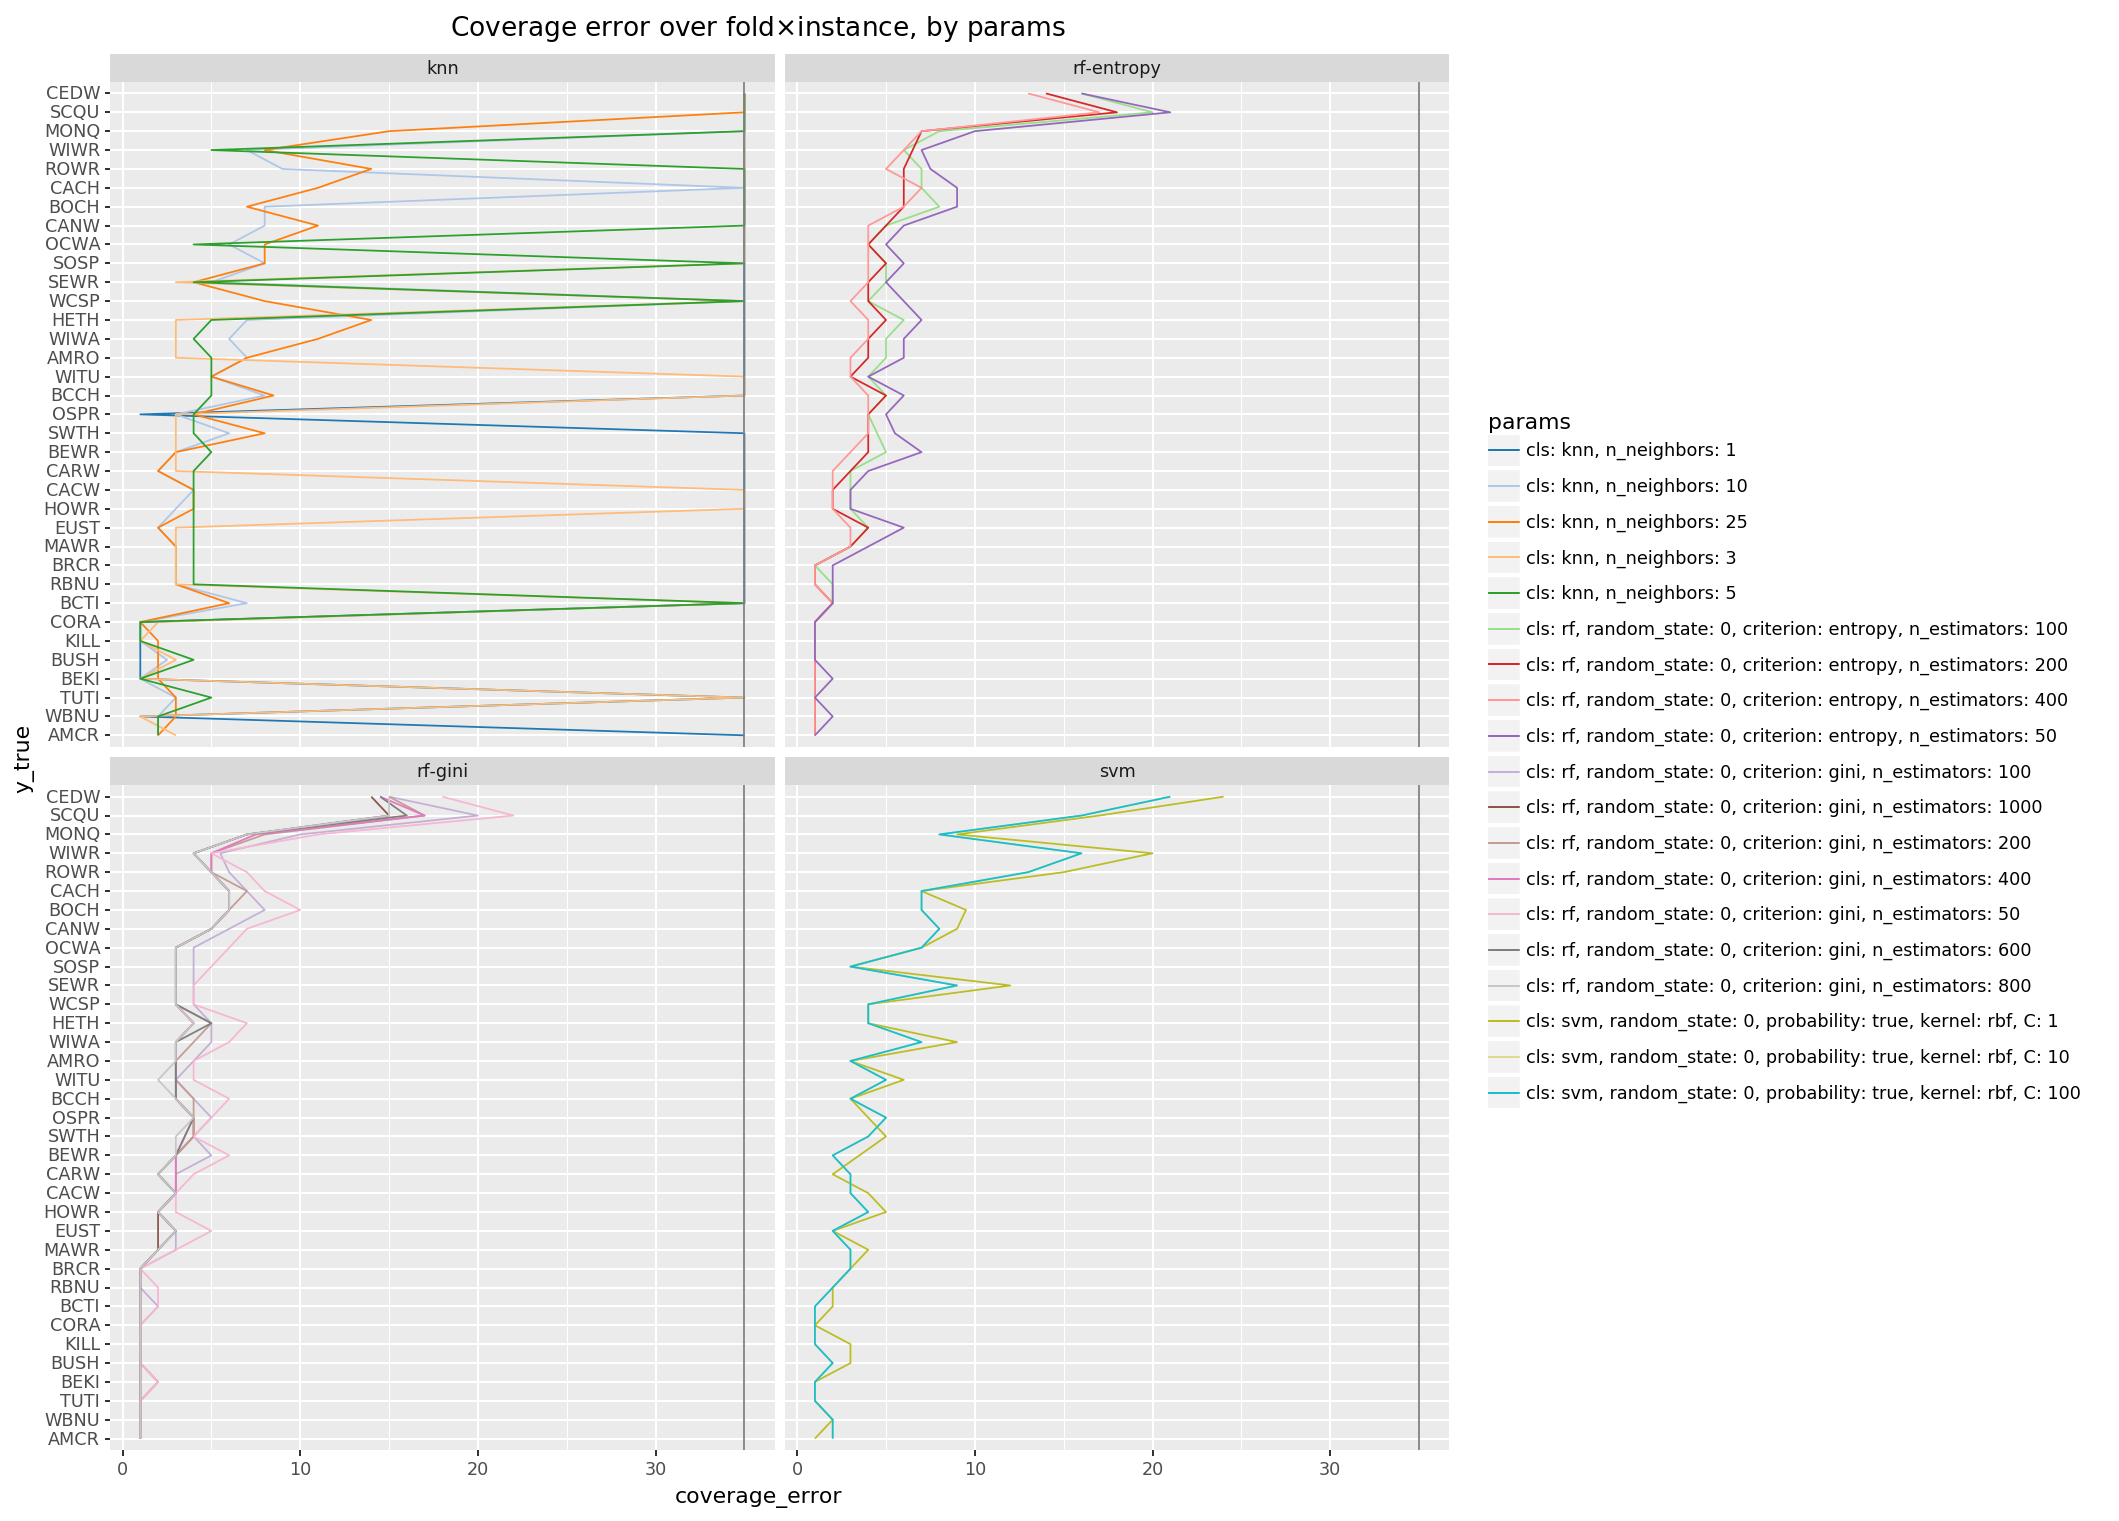

<ggplot: (318814798)>

In [ ]:
# Facet by classifier_type, order by median(coverage_error)
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
(coverage_errors_all_all
    # Sort species by median(coverage_error) (across all models)
    .pipe(df_ordered_cat, y_true=lambda df: (
        df.groupby('y_true').agg({'coverage_error': np.median}).reset_index().sort_values('coverage_error').y_true
    ))
    .pipe(ggplot, aes(x='y_true', y='coverage_error', color='params'))
    + facet_wrap('classifier_type')
    + geom_line(aes(group='params'), stat='summary', fun_y=np.median)
    + coord_flip()
    + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + scale_color_cmap_d(mpl.cm.tab20)
    + theme_figsize('square')
    + ggtitle(rf'Coverage error over fold$\times$instance, by params')
)

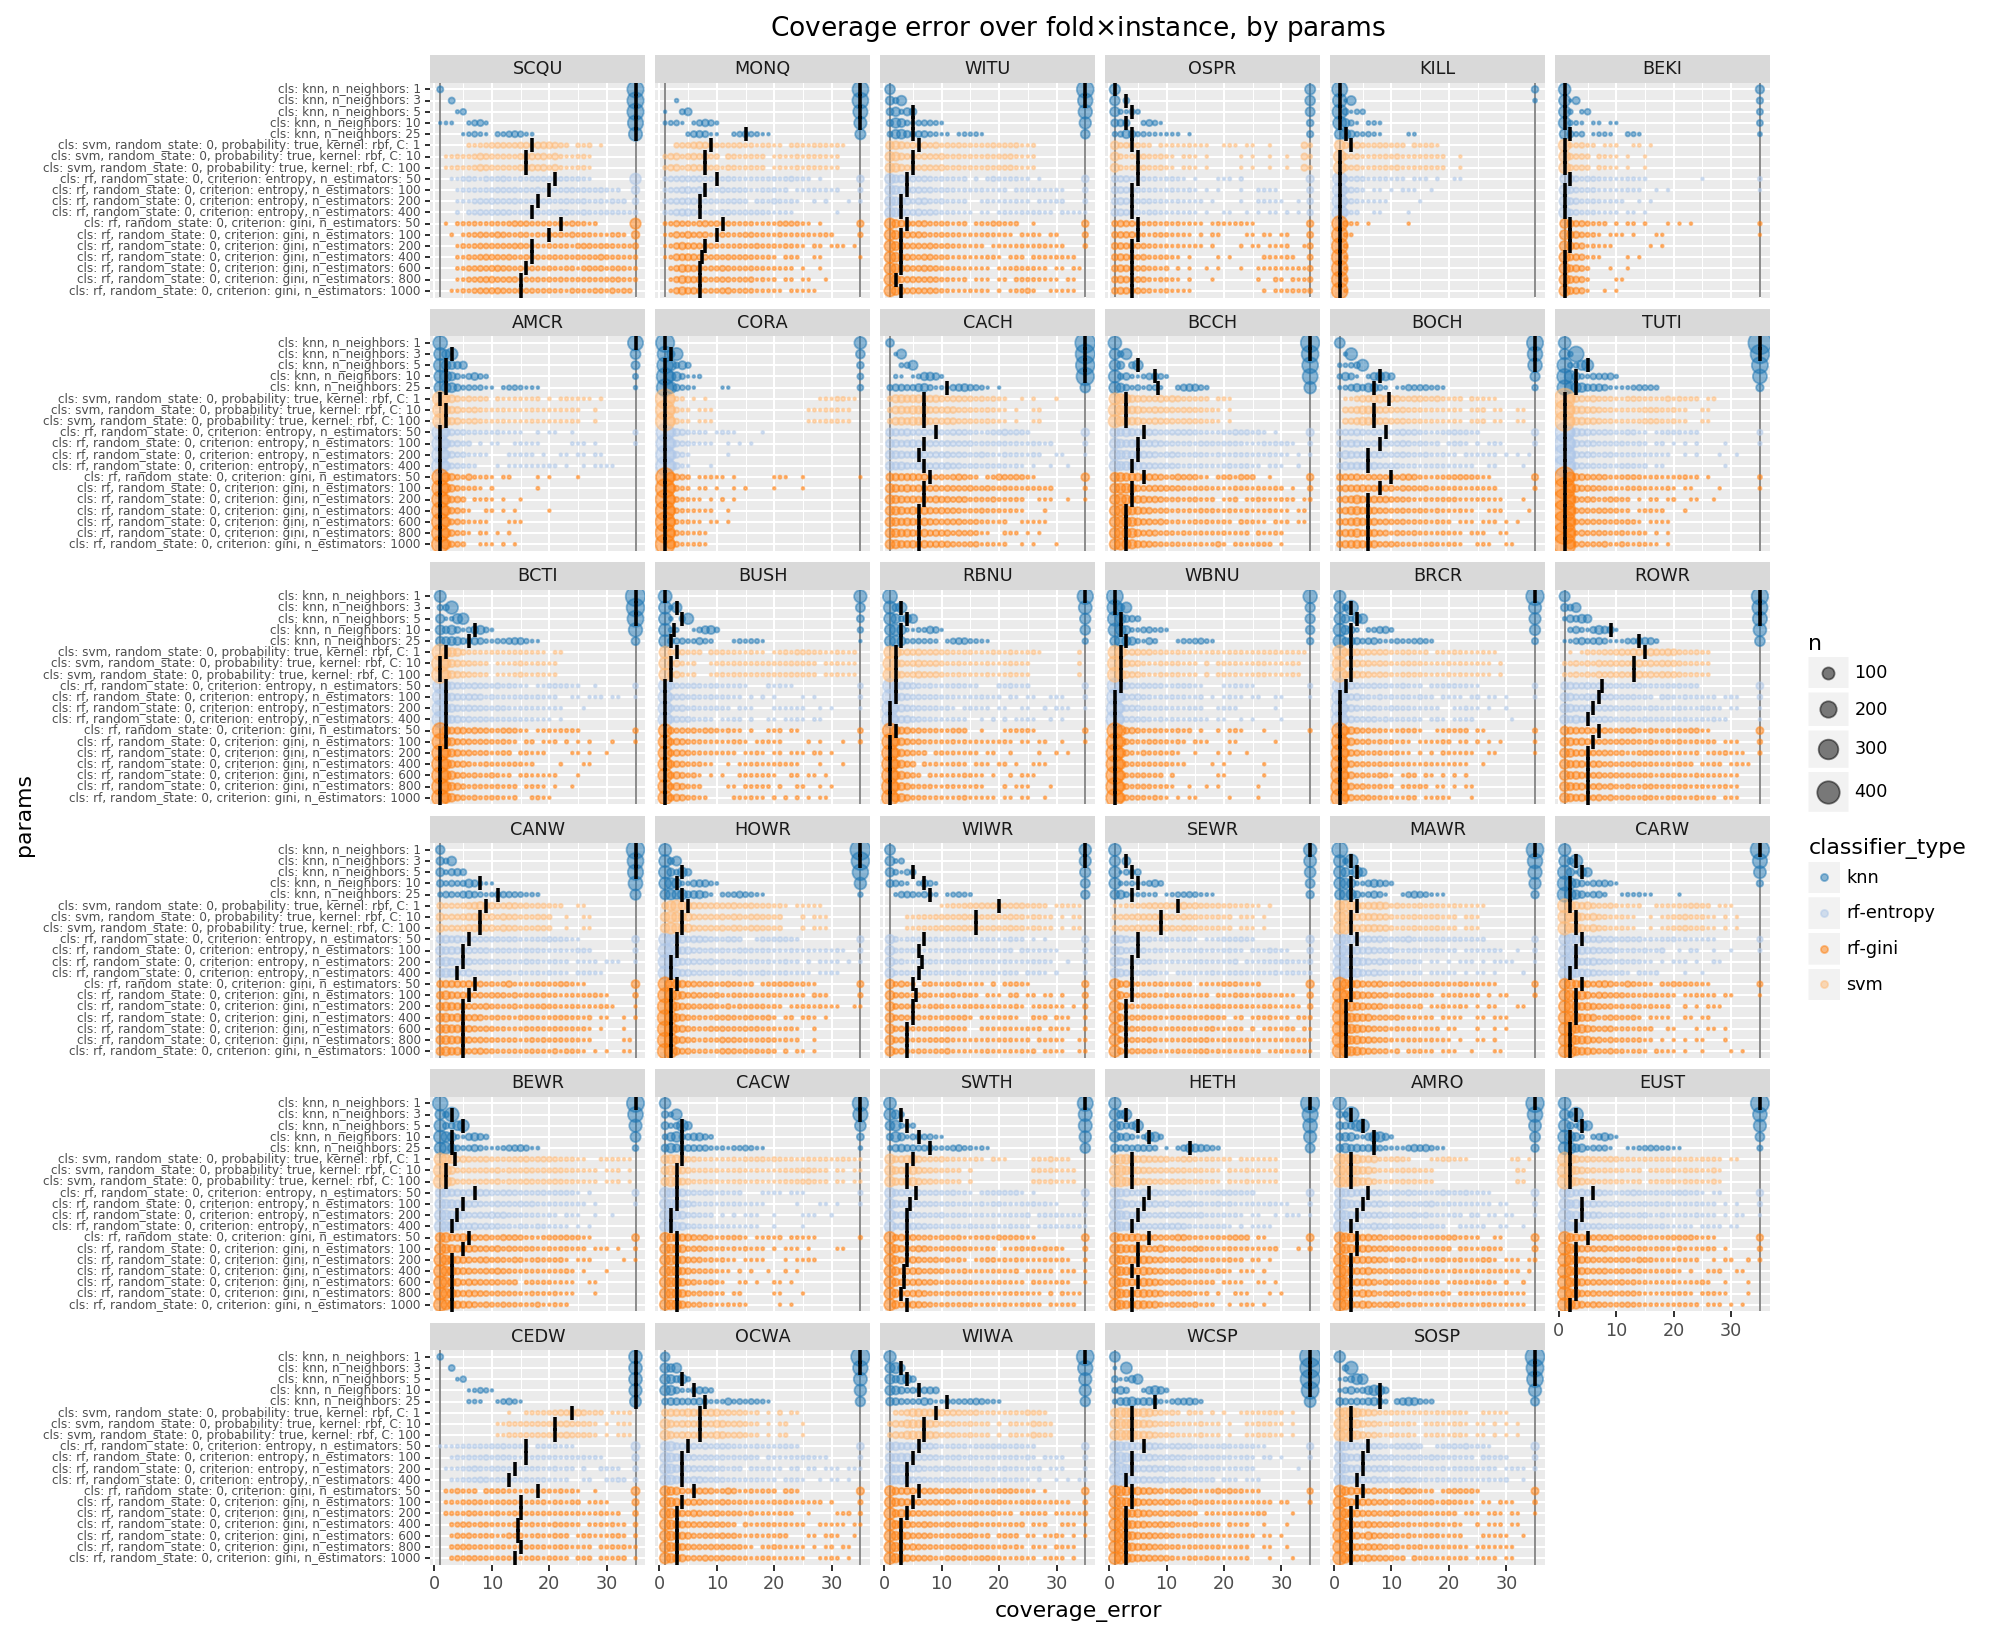

<ggplot: (322104889)>

In [ ]:
# TODO Slow, bad for notebook dev loop -- move lower, or disable by default?
# Facet by species
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
(coverage_errors_all_all
    # .sample(200, random_state=0)  # Faster dev
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_ordered_cat, params=lambda df: reversed(param_grid['classifier']))
    .pipe(ggplot, aes(x='params', y='coverage_error', color='classifier_type'))
    + facet_wrap('y_true')
    + geom_hline(yintercept=1, color='grey')
    + geom_hline(yintercept=recs.species.nunique(), color='grey')

    # Percentiles (faster, no overplot)
    # + geom_point(stat='summary', fun_y=np.median)
    # + geom_linerange(stat='summary', fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75))

    # Violin (slow, no overplot)
    # + geom_violin()

    # Boxplot (very slow, no overplot)
    # + geom_boxplot()

    # Points (medium cost, high overplot)
    #   - n (count) instead of prop (proportion)
    #   - scale_size_area() instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_count(aes(size='..n..'), alpha=.5)
    + scale_size_area()
    + geom_point(stat='summary', fun_y=np.median, alpha=1, color='black', shape='|', size=3, stroke=1)

    + coord_flip()
    + scale_color_cmap_d(mpl.cm.tab20)
    + theme(axis_text_y=element_text(size=6))
    + theme_figsize('square')  # Faster
    # + theme_figsize('half')
    # + theme_figsize('full')
    + ggtitle(rf'Coverage error over fold$\times$instance, by params')
)

# Model diagnostics: one model, all folds

In [ ]:
params_i = 18
params = param_grid['classifier'][params_i]
print("param_grid['classifier']:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(param_grid['classifier'])))
print()
print('models:')
print('  params[%s/%s]: %r' % (params_i, len(param_grid['classifier']), params))
print('  fold[*/%s]' % cv.cv.n_splits)

param_grid['classifier']:
  0: 'cls: knn, n_neighbors: 1'
  1: 'cls: knn, n_neighbors: 3'
  2: 'cls: knn, n_neighbors: 5'
  3: 'cls: knn, n_neighbors: 10'
  4: 'cls: knn, n_neighbors: 25'
  5: 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 1'
  6: 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 10'
  7: 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 100'
  8: 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 50'
  9: 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 100'
  10: 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 200'
  11: 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 400'
  12: 'cls: rf, random_state: 0, criterion: gini, n_estimators: 50'
  13: 'cls: rf, random_state: 0, criterion: gini, n_estimators: 100'
  14: 'cls: rf, random_state: 0, criterion: gini, n_estimators: 200'
  15: 'cls: rf, random_state: 0, criterion: gini, n_estimators: 400'
  16: 'cls: rf, random_state: 0, cri

In [ ]:
# Coverage errors: one model, all folds
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_one_all = (coverage_errors_all_all
    [lambda df: df.params == params]  # One model, all folds
)
display(
    df_summary(coverage_errors_one_all).T,
    coverage_errors_one_all[:10],
)

min                                                                      25%                                                                      50%                                                                      75%                                                                      max
                dtype   sizeof  len   count nunique mean std                                                                                                                                                                                                                                                                                                                                                                            
model_id        object  1313746 10700 10700 100     NaN  NaN  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 30  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 53  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 76  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 99
params          object  3830600 10700 10700 1       NaN  NaN           cls: rf, random_state: 0, criterion: gini, n_estimators: 1000            cls: rf, random_state: 0, criterion: gini, n_estimators: 1000            cls: rf, random_state: 0, criterion: gini, n_estimators: 1000            cls: rf, random_state: 0, criterion: gini, n_estimators: 1000            cls: rf, random_state: 0, criterion: gini, n_estimators: 1000
classifier_type object  599200  10700 10700 1       NaN  NaN                                                                 rf-gini                                                                  rf-gini                                                                  rf-gini                                                                  rf-gini                                                                  rf-gini
fold            int64   299172  10700 10700 100     NaN  NaN                                                                       0                                                                       24                                                                       49                                                                       74                                                                       99
i               int64   299524  10700 10700 535     NaN  NaN                                                                       0                                                                      132                                                                      264                                                                      400                                                                      534
y_true          object  909500  10700 10700 35      NaN  NaN                                                                    AMCR                                                                     BUSH                                                                     HOWR                                                                     SEWR                                                                     WIWR
coverage_error  float64 256800  10700 10700 35      NaN  NaN                                                                       1                                                                        1                                                                        2                                                                        6                                                                       35

model_id                                                         params classifier_type  fold    i y_true  coverage_error
192600  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000         rf-gini     0  172   BCTI             1.0
192601  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000         rf-gini     0  464   CEDW            13.0
192602  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000         rf-gini     0  196   BUSH             3.0
192603  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000         rf-gini     0  414   HETH             3.0
192604  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000         rf-gini     0  531   SOSP             2.0
192605  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000         rf-gini     0  210   RBNU             4.0
192606  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000         rf-gini     0  485   WIWA             9.0
192607  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000         rf-gini     0  236   BRCR             1.0
192608  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000         rf-gini     0  419   HETH             2.0
192609  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000         rf-gini     0  162   TUTI             2.0

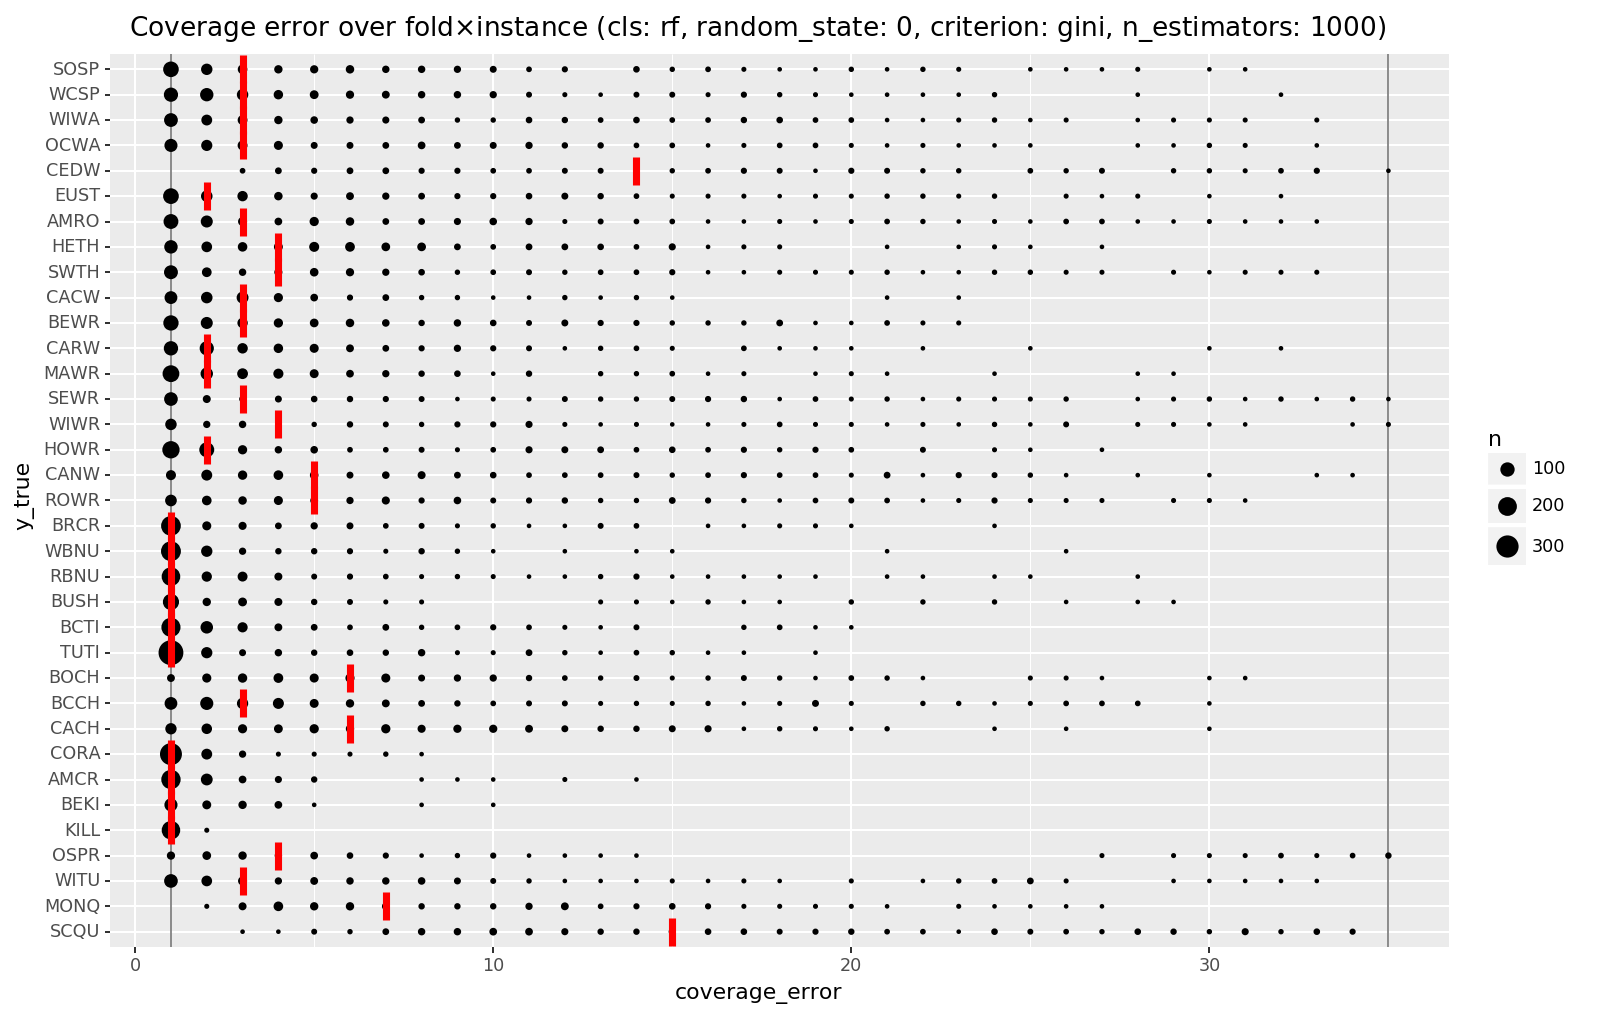

<ggplot: (-9223372036525711826)>

In [ ]:
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i].groupby(y_true) for model)
#       - Over: fold, rec_id
#   - Dims: y_true
#   - Metrics: count, coverage_error.percentiles
# in: coverage_errors_one_all, recs
(coverage_errors_one_all
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_ordered_cat, params=lambda df: reversed(param_grid['classifier']))
    .pipe(ggplot, aes(x='y_true', y='coverage_error'))
    + geom_hline(yintercept=1, color='grey')
    + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + geom_count(aes(size='..n..'), alpha=1)  # n (count) instead of prop (proportion)
    + scale_size_area()  # Instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_point(stat='summary', fun_y=np.median, alpha=1, color='red', shape='|', size=6, stroke=2)
    + coord_flip()
    + theme_figsize('inline')
    + ggtitle(rf'Coverage error over fold$\times$instance ({params})')
)

In [ ]:
(coverage_errors_one_all
    [:5]
)

model_id                                                         params classifier_type  fold    i y_true  coverage_error
192600  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000         rf-gini     0  172   BCTI             1.0
192601  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000         rf-gini     0  464   CEDW            13.0
192602  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000         rf-gini     0  196   BUSH             3.0
192603  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000         rf-gini     0  414   HETH             3.0
192604  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000         rf-gini     0  531   SOSP             2.0

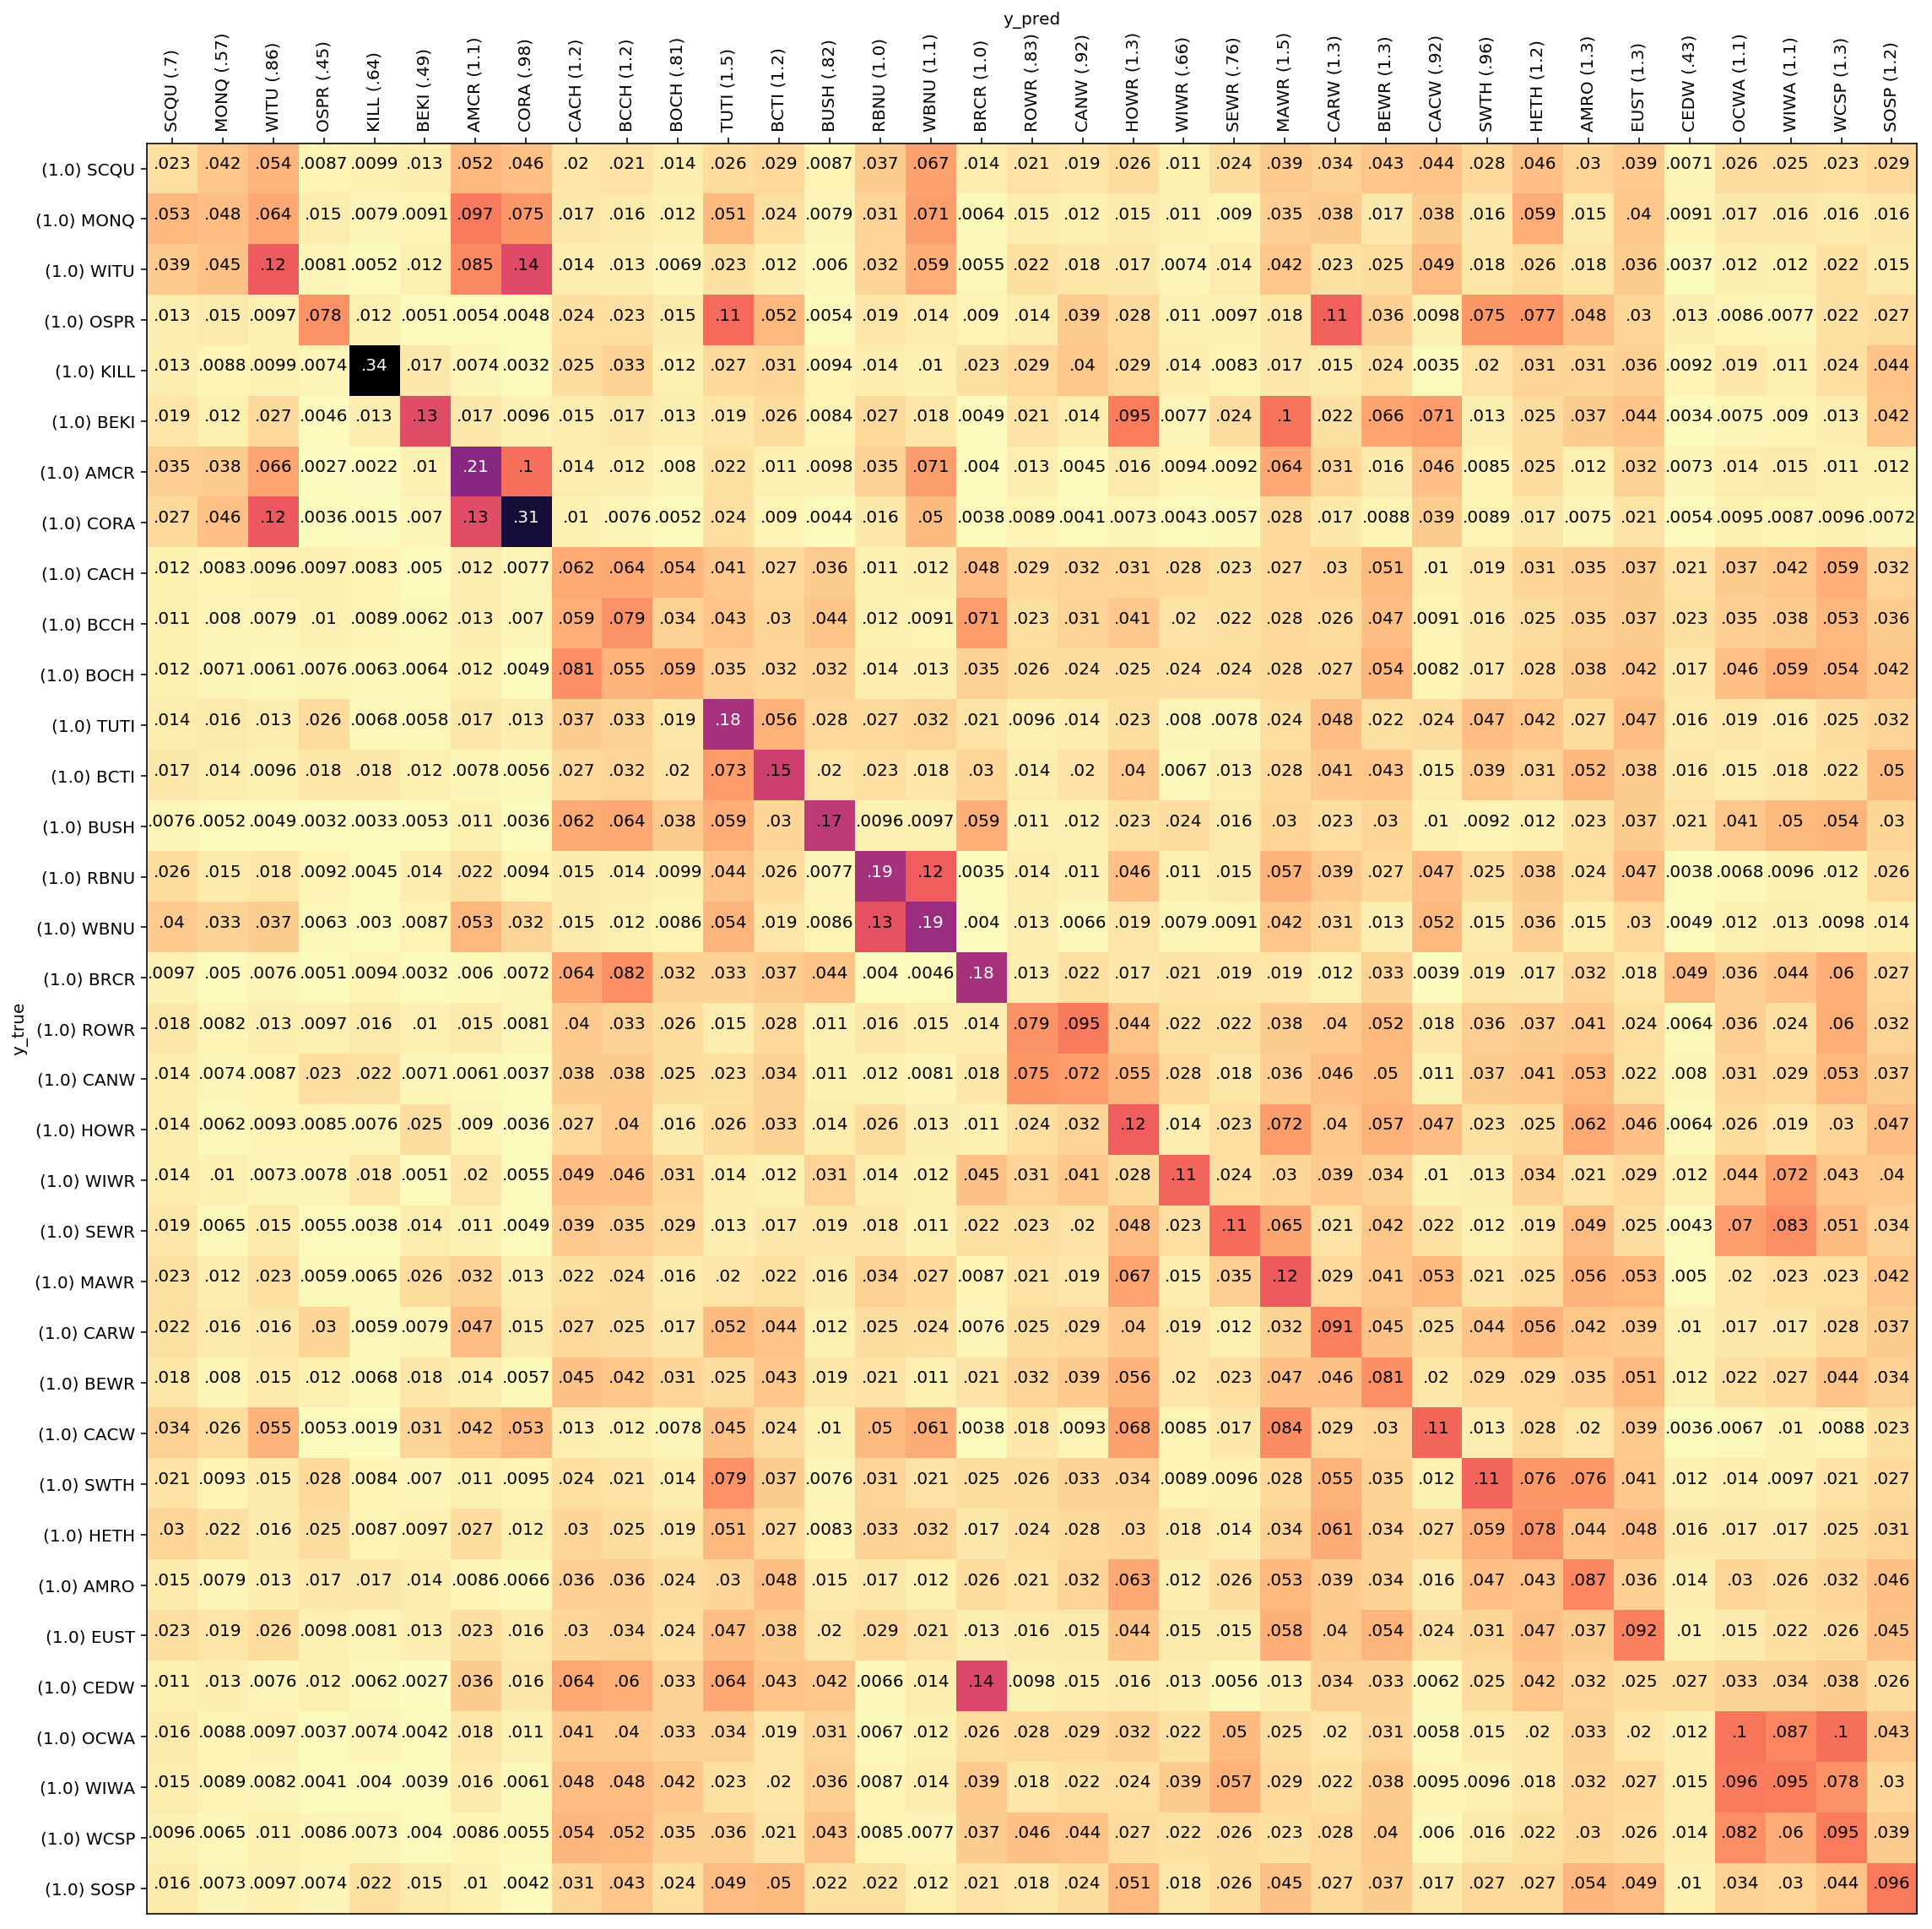

In [ ]:
# One-model/all-folds confusion matrix
with figsize('full'):
    (cv_models
        [lambda df: df.params == params]
        .pipe(lambda df: plot_confusion_matrix(
            classes=df.iloc[0].test_evals.classes,
            M=np.array([
                row.test_evals.confusion_matrix_prob()
                for row in df_rows(df)
            ]).sum(axis=0),
            # normalize=False,  # For counts
            # raw=True, scale=10,  # Faster dev
        ))
    )

# Model diagnostics: one model, one fold

In [ ]:
fold = 0
# params_i = ...  # Comment out to reuse from above
params = param_grid['classifier'][params_i]
[(_, model)] = list(cv_models[lambda df: (df.params == params) & (df.fold == fold)].iterrows())
print("param_grid['classifier']:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(param_grid['classifier'])))
print()
print('model:')
print('  params[%s/%s]: %r' % (params_i, len(param_grid['classifier']), model.params))
print('  fold[%s/%s]' % (model.fold, cv.cv.n_splits))
print()
print(model)

param_grid['classifier']:
  0: 'cls: knn, n_neighbors: 1'
  1: 'cls: knn, n_neighbors: 3'
  2: 'cls: knn, n_neighbors: 5'
  3: 'cls: knn, n_neighbors: 10'
  4: 'cls: knn, n_neighbors: 25'
  5: 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 1'
  6: 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 10'
  7: 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 100'
  8: 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 50'
  9: 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 100'
  10: 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 200'
  11: 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 400'
  12: 'cls: rf, random_state: 0, criterion: gini, n_estimators: 50'
  13: 'cls: rf, random_state: 0, criterion: gini, n_estimators: 100'
  14: 'cls: rf, random_state: 0, criterion: gini, n_estimators: 200'
  15: 'cls: rf, random_state: 0, criterion: gini, n_estimators: 400'
  16: 'cls: rf, random_state: 0, cri

In [ ]:
# in: model
model_id = model.model_id
params = model.params
fold = model.fold
# train_evals = model.train_evals
test_evals = model.test_evals

# in: model, recs
# train_recs = recs.iloc[train_evals.i]
# train_X = Search.X(recs)[train_evals.i]
# train_y = Search.y(recs)[train_evals.i]
test_recs = recs.iloc[test_evals.i]
test_X = Search.X(recs)[test_evals.i]
test_y = Search.y(recs)[test_evals.i]  # (Don't need to store cv_models.test_evals.y if we have recs -- which sometimes we don't?)

display(
    # len(train_recs),
    len(test_recs),
)

107

In [ ]:
# TODO TODO What's worth recovering here, given the plots above?
# # TODO Update [kill the .merge, then species -> y_true]
# (search.coverage_error_by(test_recs, 'id')
#     [:5]
#     # .merge(test_recs[['id', 'species']], on='id', how='left')
#     # .pipe(ggplot, aes(x='species', y='coverage_error'))
#     # + geom_count(aes(size='..n..'))
#     # + stat_summary(fun_y=np.median, geom='point', color='red', alpha=.5, shape='|', size=6, stroke=1)
#     # + stat_summary(
#     #     fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75), geom='linerange', color='red', alpha=.5, size=1,
#     # )
#     # + coord_flip()
#     # + geom_hline(yintercept=len(search.classes_), color='grey')
#     # + scale_x_discrete(limits=list(reversed(test_recs.species.cat.categories)))
#     # + theme_figsize('square')
#     # + ggtitle(rf'Coverage error over instance ({model_id})')
# )

/Users/danb/hack/bubo/features/viz.py:192: RuntimeWarning: invalid value encountered in true_divide
  M = M.astype('float') / M.sum(axis=1)[:, np.newaxis]


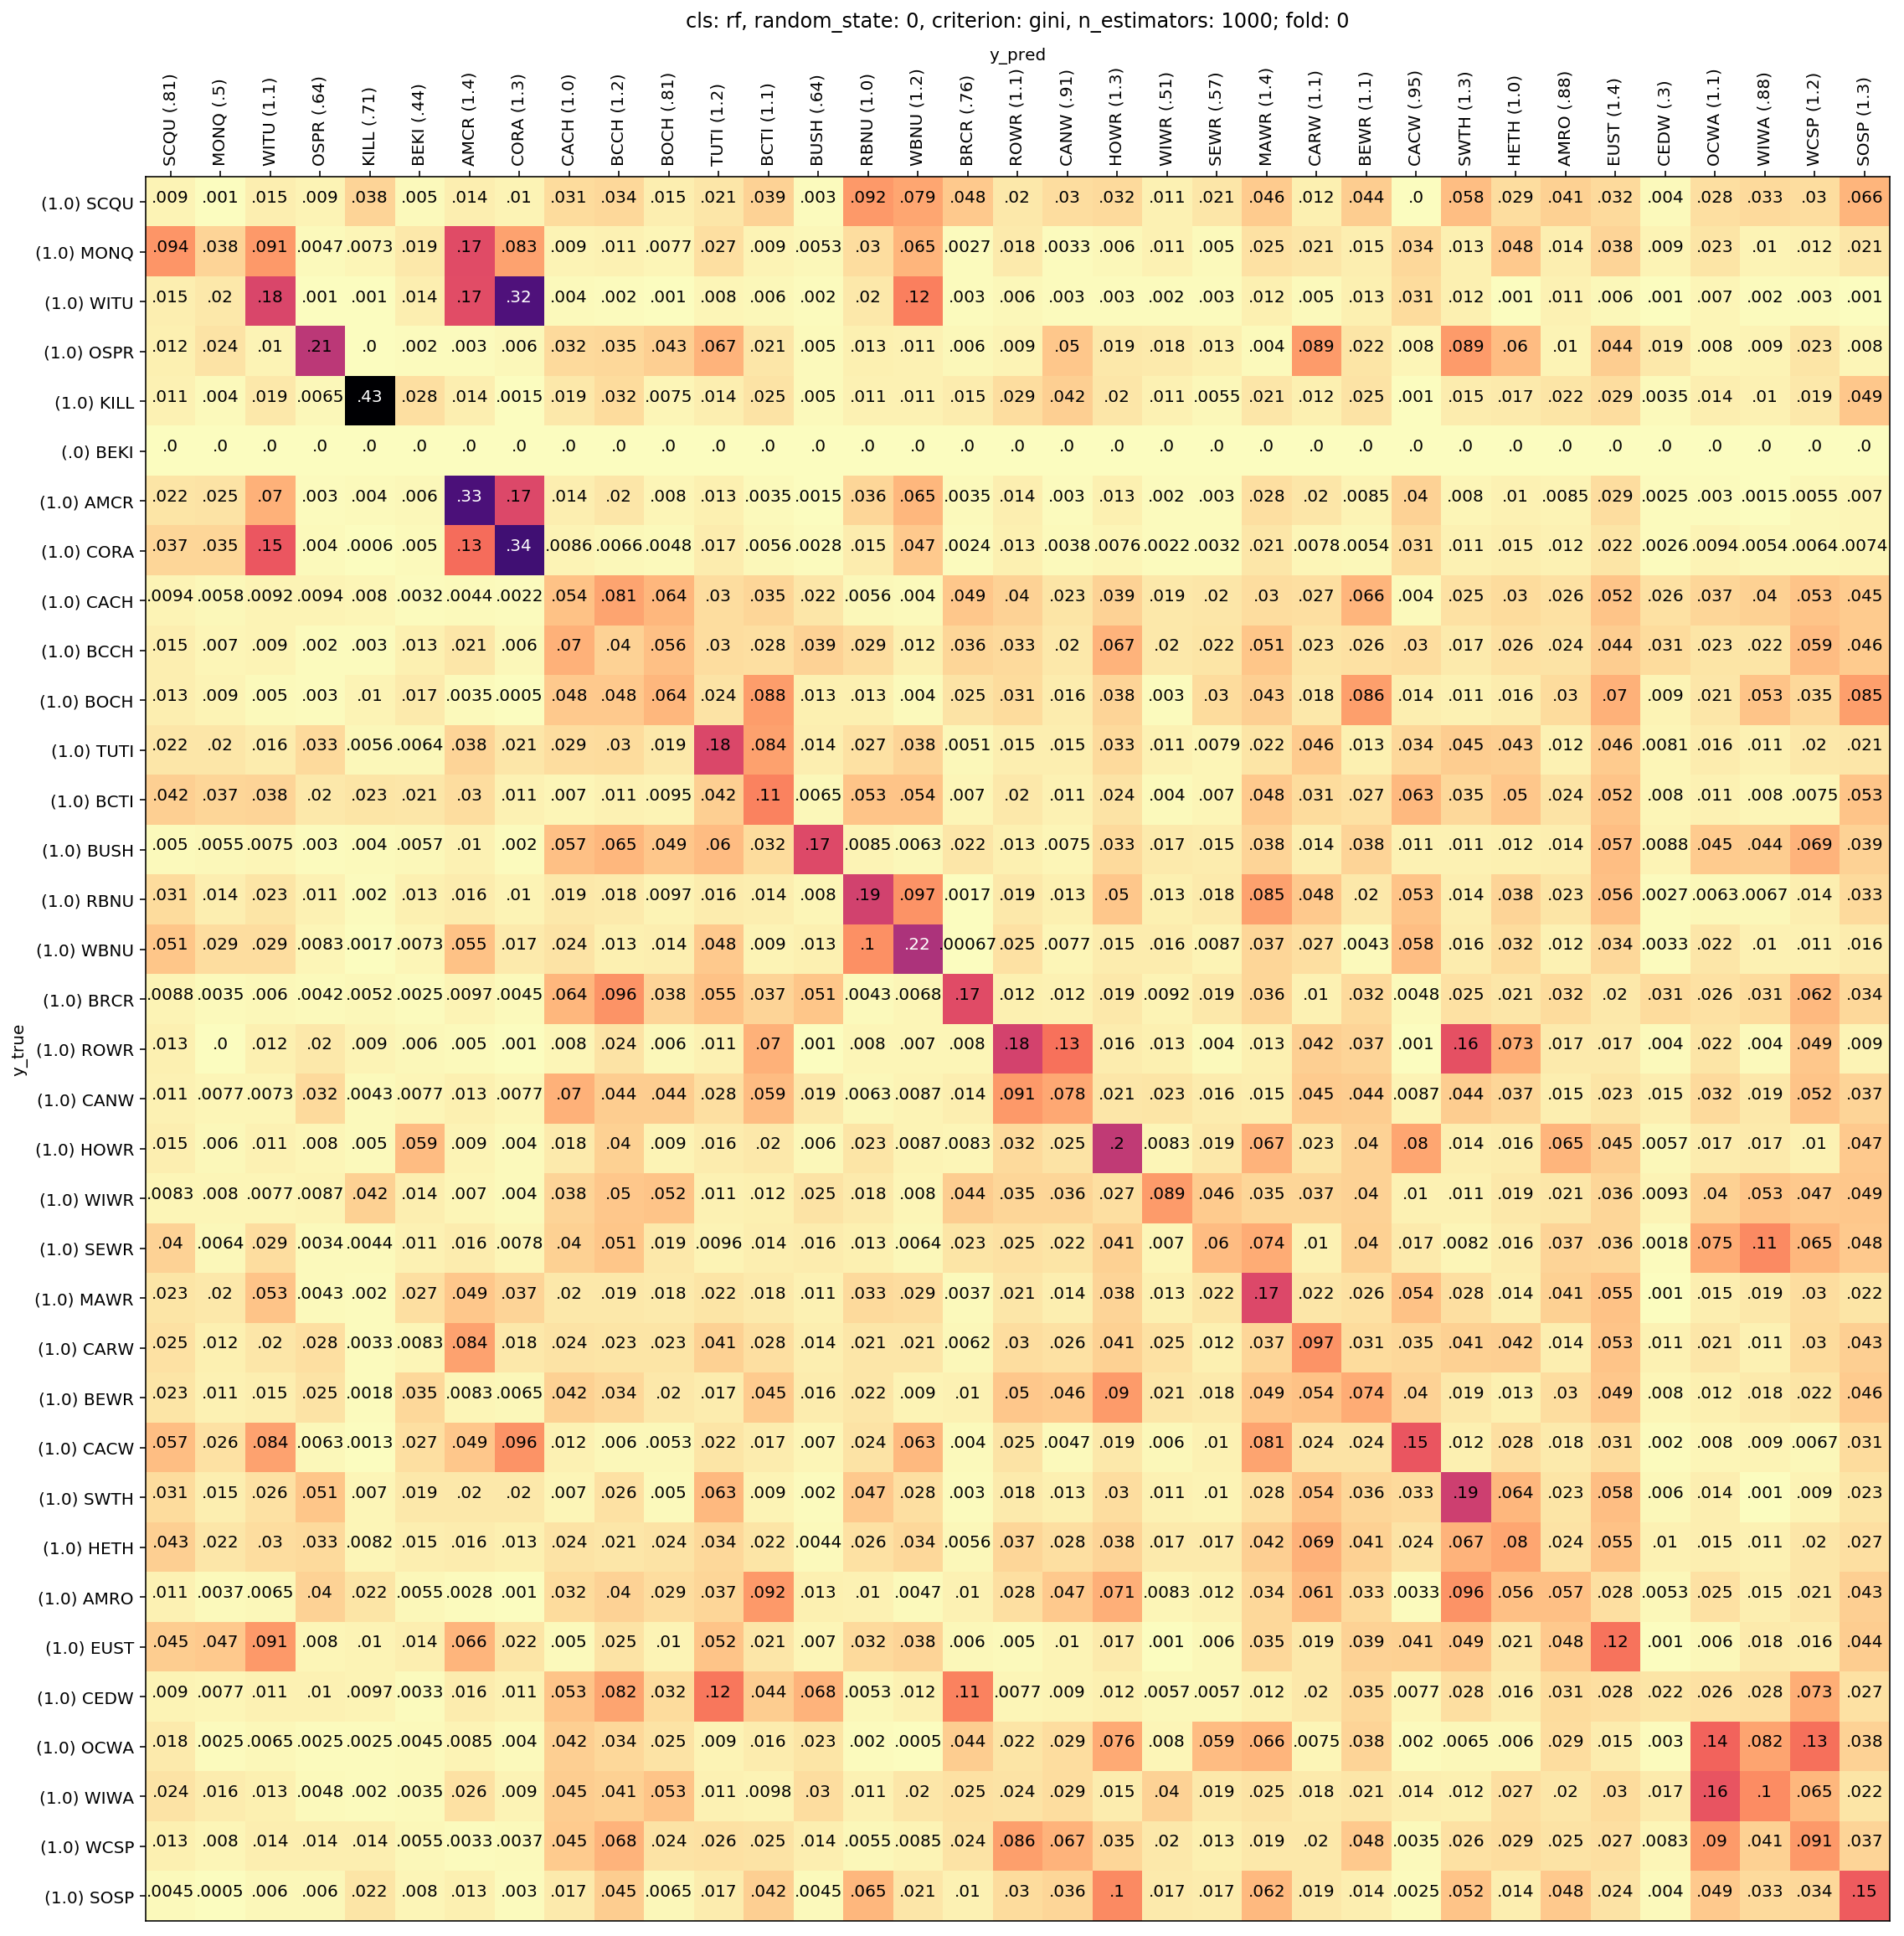

In [ ]:
# One-model/one-fold confusion matrix
with figsize('full'):
    plot_confusion_matrix_df(
        confusion_matrix_prob_df(model.test_evals.y, model.test_evals.y_scores, model.test_evals.classes),
        title=model.model_id,
        # normalize=False,  # For counts
        # raw=True, scale=10,  # Faster dev
    )